# **Bibliotecas e Instalações**

In [1]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

In [3]:
# !pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

In [4]:
figures_path = '/content/drive/MyDrive/Trabalho/Cancer/Predição cruzada/Sobrevida 3 anos/Figuras'

In [5]:
def plot_confusion_matrix_v2(model, x, y, format='.5f', ax=None):
    """
    Plota uma matriz de confusão normalizada e um relatório de classificação.

    Parâmetros:
    -----------
    model : estimador
        Um modelo de classificação já treinado.
    x : array-like, shape (n_samples, n_features)
        Conjunto de teste com as features.
    y : array-like, shape (n_samples,)
        Conjunto de teste com o label.
    format : str, opcional (padrão='.3f')
        O formato a ser usado para os valores na matriz de confusão.

    Retorno:
    --------
    None

    """
    with plt.rc_context({'font.size': 10, 'font.weight': 'bold'}):
        ConfusionMatrixDisplay.from_estimator(model, x, y, values_format=format,
                                              cmap='binary', normalize='true',
                                              ax=ax, colorbar=False)

# **Individuais**

In [6]:
# Baixando o arquivo dos tipos de câncer
!gdown 1l4ntkr4XJkxzNp7odnONu68ypwuJyZ8p --quiet # Mais incidentes

# Leitura dos dados
df = pd.read_csv('incid.csv')
print(df.shape)
df.head(3)

(521682, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,79,1,3518701,9,1,C199,C19,IIIB,E,0,...,7,3518701,1,2.0,1,0,1,1,0,0
1,68,2,3518701,9,1,C180,C18,IIA,E,0,...,7,3518701,1,2.0,1,0,1,1,1,0
2,51,2,3518701,2,1,C180,C18,IIIA,E,0,...,7,3518701,1,3.0,1,0,1,0,0,0


In [7]:
# Dados
# Mama
df_mama = df[df.TOPOGRUP.isin(['C50'])]
df_mama = df_mama[~((df_mama.obito_geral == 0) & (df_mama.sobrevida_ano3 == 0))].reset_index(drop=True)

# Pele
df_pele = df[df.TOPOGRUP.isin(['C44'])]
df_pele = df_pele[~((df_pele.obito_geral == 0) & (df_pele.sobrevida_ano3 == 0))].reset_index(drop=True)

# Próstata
df_prost = df[df.TOPOGRUP.isin(['C61'])]
df_prost = df_prost[~((df_prost.obito_geral == 0) & (df_prost.sobrevida_ano3 == 0))].reset_index(drop=True)

# Colorretal
df_colo = df[df.TOPOGRUP.isin(['C18', 'C19', 'C20'])]
df_colo = df_colo[~((df_colo.obito_geral == 0) & (df_colo.sobrevida_ano3 == 0))].reset_index(drop=True)

# Pulmão
df_pulm = df[df.TOPOGRUP.isin(['C34'])]
df_pulm = df_pulm[~((df_pulm.obito_geral == 0) & (df_pulm.sobrevida_ano3 == 0))].reset_index(drop=True)

# Colo de Útero
df_colo_utero = df[df.TOPOGRUP.isin(['C53'])]
df_colo_utero = df_colo_utero[~((df_colo_utero.obito_geral == 0) & (df_colo_utero.sobrevida_ano3 == 0))].reset_index(drop=True)

df_mama.shape, df_pele.shape, df_prost.shape, df_colo.shape, df_pulm.shape, df_colo_utero.shape

((104532, 32),
 (100884, 32),
 (83445, 32),
 (56111, 32),
 (37005, 32),
 (21470, 32))

## **Mama**

In [8]:
# Leitura dos dados de mama
print(df_mama.shape)
df_mama.head(3)

(104532, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,41,2,3548500,9,1,C504,C50,IIIB,E,0,...,7,3518701,1,3.0,0,0,0,1,1,1
1,33,2,3518701,9,1,C509,C50,IV,E,0,...,7,3518701,1,4.0,1,0,1,0,0,0
2,79,2,3518701,9,1,C500,C50,IIA,I,0,...,7,3518701,1,2.0,1,0,1,1,1,1


In [9]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_mama, X_test_mama, y_train_mama, y_test_mama, feat_cols, enc, norm = preprocessing(df_mama,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (78399, 23), X_test = (26133, 23)
y_train = (78399,), y_test = (26133,)


### **XGBoost**


#### **Modelo base**

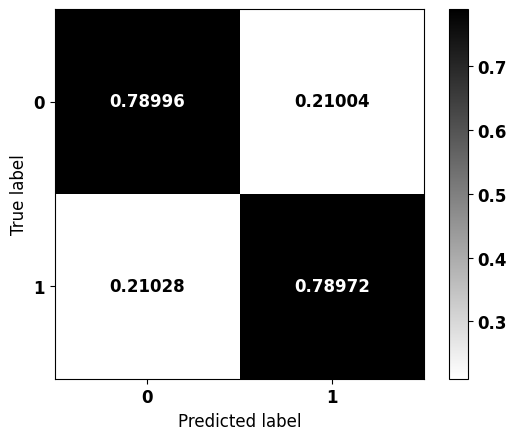


              precision    recall  f1-score   support

           0    0.48153   0.78996   0.59833      5180
           1    0.93830   0.78972   0.85762     20953

    accuracy                        0.78977     26133
   macro avg    0.70991   0.78984   0.72798     26133
weighted avg    0.84776   0.78977   0.80623     26133



In [10]:
# Criação e treinamento do modelo XGBoost
xgb_mama = XGBClassifier(max_depth=4,
                         scale_pos_weight=0.2197,
                         random_state=seed)

xgb_mama.fit(X_train_mama, y_train_mama)

# Matriz de confusão
plot_confusion_matrix(xgb_mama, X_test_mama, y_test_mama)

#### **Optuna**

In [11]:
params = {'n_estimators': 114,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

params['scale_pos_weight'] = 0.2196
params['random_state'] = seed

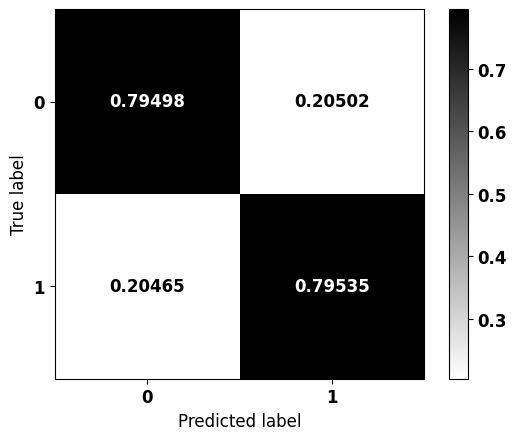


              precision    recall  f1-score   support

           0    0.48989   0.79498   0.60621      5180
           1    0.94009   0.79535   0.86169     20953

    accuracy                        0.79528     26133
   macro avg    0.71499   0.79517   0.73395     26133
weighted avg    0.85085   0.79528   0.81105     26133



In [12]:
# Modelo com os melhores parâmetros
xgb_optuna_mama = XGBClassifier()
xgb_optuna_mama.set_params(**params)

xgb_optuna_mama.fit(X_train_mama, y_train_mama)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_mama, X_test_mama, y_test_mama)

### **LightGBM**


#### **Modelo base**

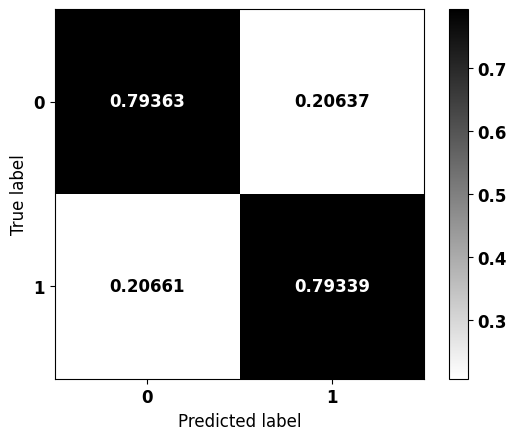


              precision    recall  f1-score   support

           0    0.48709   0.79363   0.60367      5180
           1    0.93958   0.79339   0.86032     20953

    accuracy                        0.79344     26133
   macro avg    0.71333   0.79351   0.73200     26133
weighted avg    0.84989   0.79344   0.80945     26133



In [13]:
# Criação e treinamento do modelo LightGBM
lgbm_mama = LGBMClassifier(max_depth=10,
                           class_weight={0:4.44, 1:1},
                           random_state=seed,
                           verbose=-1)

lgbm_mama.fit(X_train_mama, y_train_mama)

# Matriz de confusão
plot_confusion_matrix(lgbm_mama, X_test_mama, y_test_mama)

#### **Optuna**

In [14]:
params = {'n_estimators': 149,
          'max_depth': 7,
          'learning_rate': 0.09,
          'min_child_weight': 6,
          'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:4.41, 1:1}

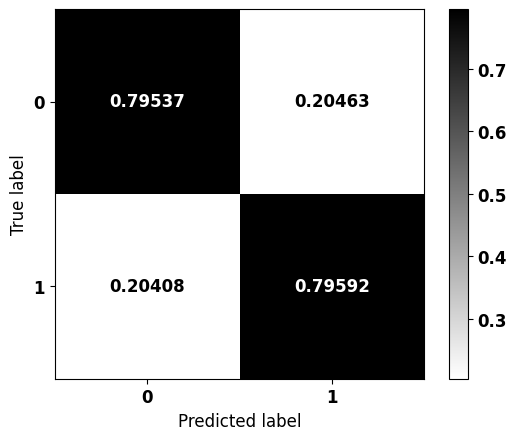


              precision    recall  f1-score   support

           0    0.49071   0.79537   0.60695      5180
           1    0.94024   0.79592   0.86208     20953

    accuracy                        0.79581     26133
   macro avg    0.71547   0.79565   0.73452     26133
weighted avg    0.85113   0.79581   0.81151     26133



In [15]:
# Modelo com os melhores parâmetros
lgbm_optuna_mama = LGBMClassifier(verbose=-1)
lgbm_optuna_mama.set_params(**params)

lgbm_optuna_mama.fit(X_train_mama, y_train_mama)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_mama, X_test_mama, y_test_mama)

### **Melhor modelo**

In [16]:
# Melhor modelo
models = [xgb_mama, xgb_optuna_mama, lgbm_mama, lgbm_optuna_mama]
for i, m in enumerate(models):
    if i == 0:
        best_mama = m
    else:
        best_score = best_mama.score(X_test_mama, y_test_mama)
        score = m.score(X_test_mama, y_test_mama)
        if score > best_score:
            best_mama = m

print(best_mama)

LGBMClassifier(class_weight={0: 4.41, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.09, max_depth=7, min_child_weight=6,
               n_estimators=149, random_state=7, verbose=-1)


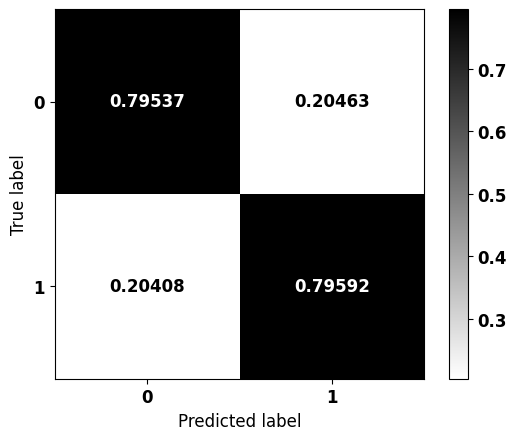


              precision    recall  f1-score   support

           0    0.49071   0.79537   0.60695      5180
           1    0.94024   0.79592   0.86208     20953

    accuracy                        0.79581     26133
   macro avg    0.71547   0.79565   0.73452     26133
weighted avg    0.85113   0.79581   0.81151     26133



In [17]:
# Matriz de confusão
plot_confusion_matrix(best_mama, X_test_mama, y_test_mama)

## **Pele**

In [18]:
# Leitura dos dados de pele
print(df_pele.shape)
df_pele.head(3)

(100884, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,42,1,3518701,9,2,C446,C44,IIIC,G,0,...,7,3518701,1,3.0,1,0,1,0,0,0
1,43,2,3548708,9,1,C449,C44,IIIC,C,0,...,1,3518701,1,4.0,0,0,1,1,0,0
2,31,2,3518701,2,2,C449,C44,IV,C,0,...,7,3518701,1,3.0,1,0,1,0,0,0


In [19]:
df_pele.dropna(inplace=True)
df_pele.shape

(100883, 32)

In [20]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_pele, X_test_pele, y_train_pele, y_test_pele, feat_cols, enc, norm = preprocessing(df_pele,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (75662, 23), X_test = (25221, 23)
y_train = (75662,), y_test = (25221,)


### **XGBoost**


#### **Modelo base**

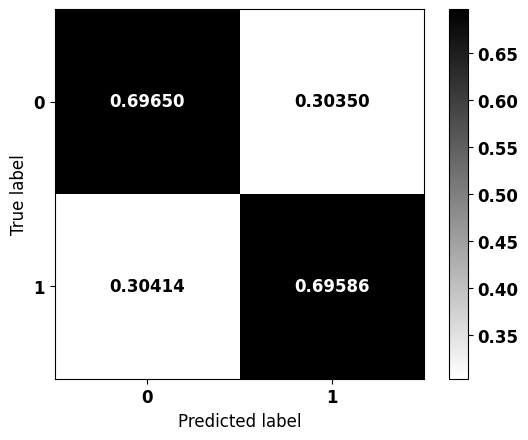


              precision    recall  f1-score   support

           0    0.40609   0.69650   0.51305      5799
           1    0.88478   0.69586   0.77903     19422

    accuracy                        0.69601     25221
   macro avg    0.64544   0.69618   0.64604     25221
weighted avg    0.77472   0.69601   0.71787     25221



In [21]:
# Criação e treinamento do modelo XGBoost
xgb_pele = XGBClassifier(max_depth=4,
                         scale_pos_weight=0.282,
                         random_state=seed)

xgb_pele.fit(X_train_pele, y_train_pele)

# Matriz de confusão
plot_confusion_matrix(xgb_pele, X_test_pele, y_test_pele)

#### **Optuna**

In [22]:
params = {'n_estimators': 136,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 4,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['scale_pos_weight'] = 0.2773

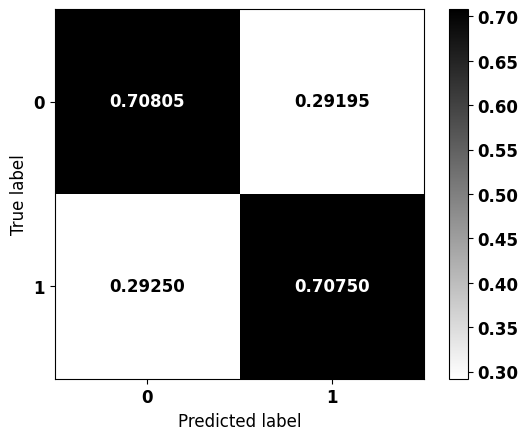


              precision    recall  f1-score   support

           0    0.41954   0.70805   0.52688      5799
           1    0.89031   0.70750   0.78844     19422

    accuracy                        0.70762     25221
   macro avg    0.65492   0.70777   0.65766     25221
weighted avg    0.78206   0.70762   0.72830     25221



In [23]:
# Modelo com os melhores parâmetros
xgb_optuna_pele = XGBClassifier()
xgb_optuna_pele.set_params(**params)

xgb_optuna_pele.fit(X_train_pele, y_train_pele)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_pele, X_test_pele, y_test_pele)

### **LightGBM**


#### **Modelo base**

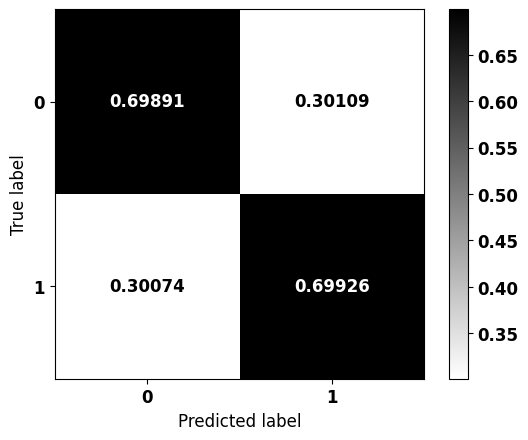


              precision    recall  f1-score   support

           0    0.40964   0.69891   0.51654      5799
           1    0.88608   0.69926   0.78166     19422

    accuracy                        0.69918     25221
   macro avg    0.64786   0.69909   0.64910     25221
weighted avg    0.77654   0.69918   0.72070     25221



In [24]:
# Criação e treinamento do modelo LightGBM
lgbm_pele = LGBMClassifier(max_depth=10,
                      class_weight={0:3.47, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm_pele.fit(X_train_pele, y_train_pele)

# Matriz de confusão
plot_confusion_matrix(lgbm_pele, X_test_pele, y_test_pele)

#### **Optuna**

In [25]:
params = {'n_estimators': 150,
 'max_depth': 10,
 'learning_rate': 0.17,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:3.5183, 1:1}

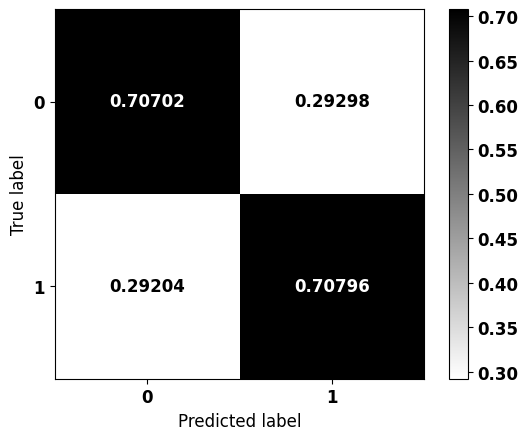


              precision    recall  f1-score   support

           0    0.41957   0.70702   0.52662      5799
           1    0.89003   0.70796   0.78862     19422

    accuracy                        0.70774     25221
   macro avg    0.65480   0.70749   0.65762     25221
weighted avg    0.78185   0.70774   0.72838     25221



In [26]:
# Modelo com os melhores parâmetros
lgbm_optuna_pele = LGBMClassifier(verbose=-1)
lgbm_optuna_pele.set_params(**params)

lgbm_optuna_pele.fit(X_train_pele, y_train_pele)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_pele, X_test_pele, y_test_pele)

### **Melhor modelo**

In [27]:
# Melhor modelo
models = [xgb_pele, xgb_optuna_pele, lgbm_pele, lgbm_optuna_pele]
for i, m in enumerate(models):
    if i == 0:
        best_pele = m
    else:
        best_score = best_pele.score(X_test_pele, y_test_pele)
        score = m.score(X_test_pele, y_test_pele)
        if score > best_score:
            best_pele = m

print(best_pele)

LGBMClassifier(class_weight={0: 3.5183, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.17, max_depth=10, min_child_weight=5,
               n_estimators=150, random_state=7, verbose=-1)


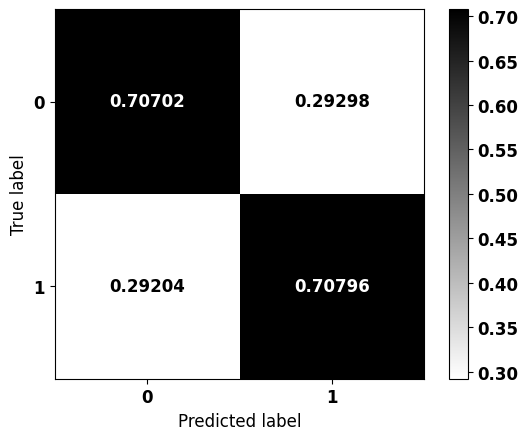


              precision    recall  f1-score   support

           0    0.41957   0.70702   0.52662      5799
           1    0.89003   0.70796   0.78862     19422

    accuracy                        0.70774     25221
   macro avg    0.65480   0.70749   0.65762     25221
weighted avg    0.78185   0.70774   0.72838     25221



In [28]:
# Matriz de confusão
plot_confusion_matrix(best_pele, X_test_pele, y_test_pele)

## **Próstata**

In [29]:
# Leitura dos dados de colo de útero
print(df_prost.shape)
df_prost.head(3)

(83445, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,74,1,3518701,9,1,C619,C61,II,I,0,...,7,3518701,1,2.0,1,0,1,1,1,1
1,78,1,3518701,9,1,C619,C61,II,I,0,...,7,3518701,1,3.0,1,0,0,1,1,1
2,60,1,3518701,9,2,C619,C61,II,I,0,...,7,3518701,1,3.0,1,0,0,1,1,1


In [30]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_prost, X_test_prost, y_train_prost, y_test_prost, feat_cols, enc, norm = preprocessing(df_prost,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (62583, 23), X_test = (20862, 23)
y_train = (62583,), y_test = (20862,)


### **XGBoost**


#### **Modelo base**

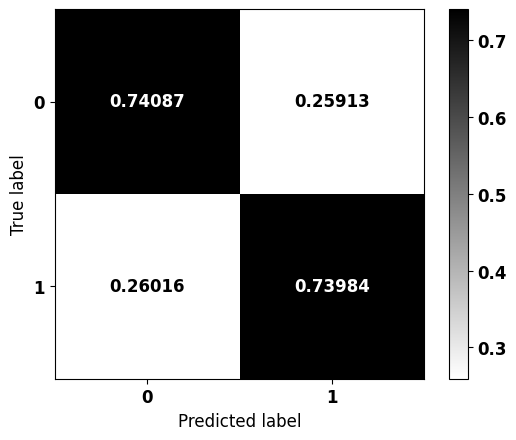


              precision    recall  f1-score   support

           0    0.35419   0.74087   0.47926      3369
           1    0.93681   0.73984   0.82675     17493

    accuracy                        0.74001     20862
   macro avg    0.64550   0.74036   0.65301     20862
weighted avg    0.84272   0.74001   0.77064     20862



In [31]:
# Criação e treinamento do modelo XGBoost
xgb_prost = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.1675,
                    random_state=seed)

xgb_prost.fit(X_train_prost, y_train_prost)

# Matriz de confusão
plot_confusion_matrix(xgb_prost, X_test_prost, y_test_prost)

#### **Optuna**

In [32]:
params = {'n_estimators': 110,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 0.1655

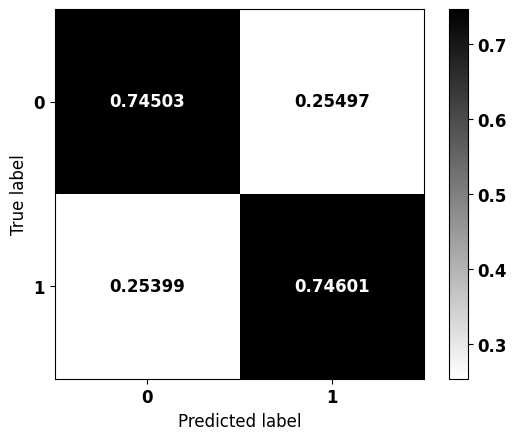


              precision    recall  f1-score   support

           0    0.36100   0.74503   0.48634      3369
           1    0.93824   0.74601   0.83116     17493

    accuracy                        0.74585     20862
   macro avg    0.64962   0.74552   0.65875     20862
weighted avg    0.84502   0.74585   0.77547     20862



In [33]:
# Modelo com os melhores parâmetros
xgb_optuna_prost = XGBClassifier()
xgb_optuna_prost.set_params(**params)

xgb_optuna_prost.fit(X_train_prost, y_train_prost)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_prost, X_test_prost, y_test_prost)

### **LightGBM**


#### **Modelo base**

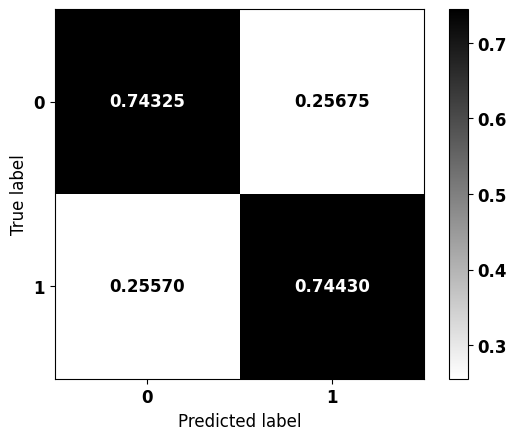


              precision    recall  f1-score   support

           0    0.35889   0.74325   0.48405      3369
           1    0.93770   0.74430   0.82988     17493

    accuracy                        0.74413     20862
   macro avg    0.64830   0.74377   0.65697     20862
weighted avg    0.84423   0.74413   0.77403     20862



In [34]:
# Criação e treinamento do modelo LightGBM
lgbm_prost = LGBMClassifier(max_depth=10,
                      class_weight={0:6.025, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm_prost.fit(X_train_prost, y_train_prost)

# Matriz de confusão
plot_confusion_matrix(lgbm_prost, X_test_prost, y_test_prost)

#### **Optuna**

In [35]:
params = {'n_estimators': 117,
 'max_depth': 6,
 'learning_rate': 0.12,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:6.041, 1:1}

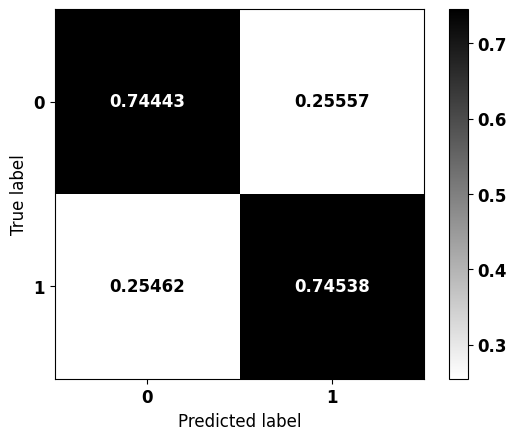


              precision    recall  f1-score   support

           0    0.36024   0.74443   0.48553      3369
           1    0.93806   0.74538   0.83069     17493

    accuracy                        0.74523     20862
   macro avg    0.64915   0.74491   0.65811     20862
weighted avg    0.84475   0.74523   0.77495     20862



In [36]:
# Modelo com os melhores parâmetros
lgbm_optuna_prost = LGBMClassifier(verbose=-1)
lgbm_optuna_prost.set_params(**params)

lgbm_optuna_prost.fit(X_train_prost, y_train_prost)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_prost, X_test_prost, y_test_prost)

### **Melhor modelo**

In [37]:
# Melhor modelo
models = [xgb_prost, xgb_optuna_prost, lgbm_prost, lgbm_optuna_prost]
for i, m in enumerate(models):
    if i == 0:
        best_prost = m
    else:
        best_score = best_prost.score(X_test_prost, y_test_prost)
        score = m.score(X_test_prost, y_test_prost)
        if score > best_score:
            best_prost = m

print(best_prost)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


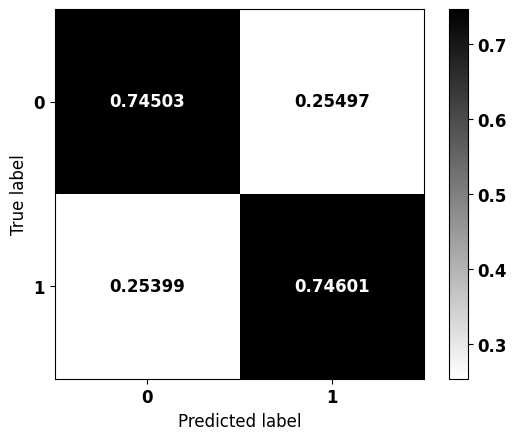


              precision    recall  f1-score   support

           0    0.36100   0.74503   0.48634      3369
           1    0.93824   0.74601   0.83116     17493

    accuracy                        0.74585     20862
   macro avg    0.64962   0.74552   0.65875     20862
weighted avg    0.84502   0.74585   0.77547     20862



In [38]:
# Matriz de confusão
plot_confusion_matrix(best_prost, X_test_prost, y_test_prost)

## **Colorretal**

In [39]:
# Leitura dos dados de colorretal
print(df_colo.shape)
df_colo.head(3)

(56111, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,79,1,3518701,9,1,C199,C19,IIIB,E,0,...,7,3518701,1,2.0,1,0,1,1,0,0
1,68,2,3518701,9,1,C180,C18,IIA,E,0,...,7,3518701,1,2.0,1,0,1,1,1,0
2,51,2,3518701,2,1,C180,C18,IIIA,E,0,...,7,3518701,1,3.0,1,0,1,0,0,0


In [40]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_colo, X_test_colo, y_train_colo, y_test_colo, feat_cols, enc, norm = preprocessing(df_colo,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (42083, 23), X_test = (14028, 23)
y_train = (42083,), y_test = (14028,)


### **XGBoost**


#### **Modelo base**

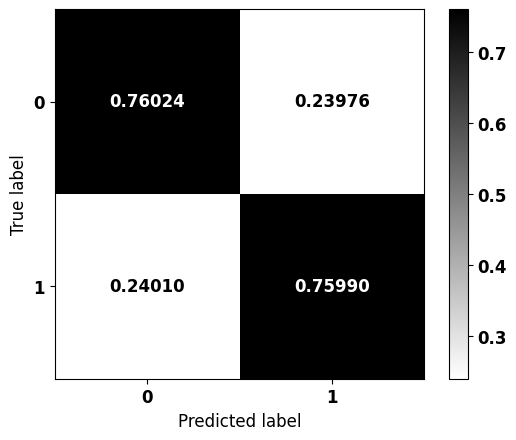


              precision    recall  f1-score   support

           0    0.71920   0.76024   0.73915      6273
           1    0.79667   0.75990   0.77785      7755

    accuracy                        0.76005     14028
   macro avg    0.75794   0.76007   0.75850     14028
weighted avg    0.76203   0.76005   0.76055     14028



In [41]:
# Criação e treinamento do modelo XGBoost
xgb_colo = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.645,
                    random_state=seed)

xgb_colo.fit(X_train_colo, y_train_colo)

# Matriz de confusão
plot_confusion_matrix(xgb_colo, X_test_colo, y_test_colo)

#### **Optuna**

In [42]:
params = {'n_estimators': 107,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'min_child_weight': 5,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 0.6488

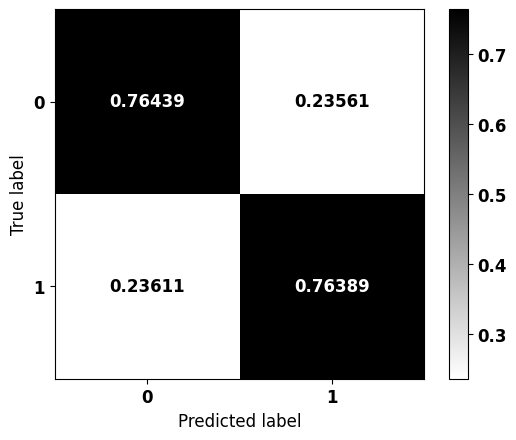


              precision    recall  f1-score   support

           0    0.72366   0.76439   0.74347      6273
           1    0.80032   0.76389   0.78169      7755

    accuracy                        0.76411     14028
   macro avg    0.76199   0.76414   0.76258     14028
weighted avg    0.76604   0.76411   0.76460     14028



In [43]:
# Modelo com os melhores parâmetros
xgb_optuna_colo = XGBClassifier()
xgb_optuna_colo.set_params(**params)

xgb_optuna_colo.fit(X_train_colo, y_train_colo)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_colo, X_test_colo, y_test_colo)

### **LightGBM**


#### **Modelo base**

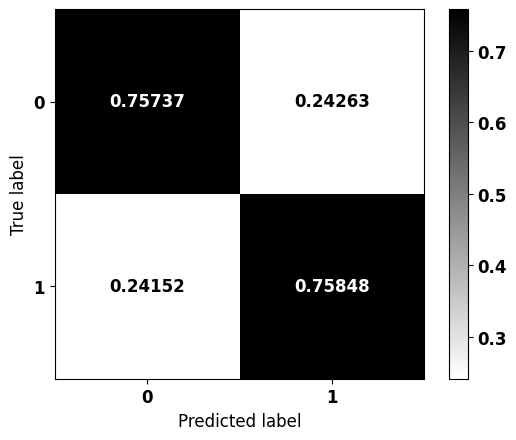


              precision    recall  f1-score   support

           0    0.71724   0.75737   0.73676      6273
           1    0.79444   0.75848   0.77604      7755

    accuracy                        0.75798     14028
   macro avg    0.75584   0.75793   0.75640     14028
weighted avg    0.75992   0.75798   0.75848     14028



In [44]:
# Criação e treinamento do modelo LightGBM
lgbm_colo = LGBMClassifier(max_depth=10,
                      class_weight={0: 1.4662, 1: 1},
                      random_state=seed,
                      verbose=-1)

lgbm_colo.fit(X_train_colo, y_train_colo)

# Matriz de confusão
plot_confusion_matrix(lgbm_colo, X_test_colo, y_test_colo)

#### **Optuna**

In [45]:
params = {'n_estimators': 143,
 'max_depth': 10,
 'learning_rate': 0.12,
 'min_child_weight': 1,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:1.4445, 1:1}

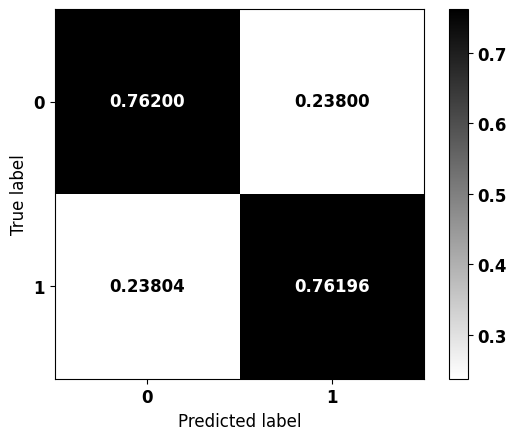


              precision    recall  f1-score   support

           0    0.72140   0.76200   0.74114      6273
           1    0.79830   0.76196   0.77971      7755

    accuracy                        0.76198     14028
   macro avg    0.75985   0.76198   0.76042     14028
weighted avg    0.76391   0.76198   0.76246     14028



In [46]:
# Modelo com os melhores parâmetros
lgbm_optuna_colo = LGBMClassifier(verbose=-1)
lgbm_optuna_colo.set_params(**params)

lgbm_optuna_colo.fit(X_train_colo, y_train_colo)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_colo, X_test_colo, y_test_colo)

### **Melhor modelo**

In [47]:
# Melhor modelo
models = [xgb_colo, xgb_optuna_colo, lgbm_colo, lgbm_optuna_colo]
for i, m in enumerate(models):
    if i == 0:
        best_colo = m
    else:
        best_score = best_colo.score(X_test_colo, y_test_colo)
        score = m.score(X_test_colo, y_test_colo)
        if score > best_score:
            best_colo = m

print(best_colo)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=107, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


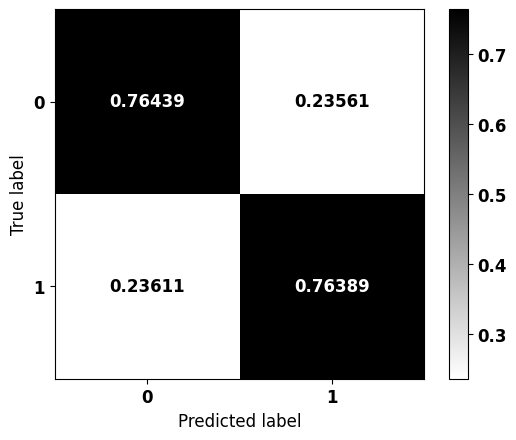


              precision    recall  f1-score   support

           0    0.72366   0.76439   0.74347      6273
           1    0.80032   0.76389   0.78169      7755

    accuracy                        0.76411     14028
   macro avg    0.76199   0.76414   0.76258     14028
weighted avg    0.76604   0.76411   0.76460     14028



In [48]:
# Matriz de confusão
plot_confusion_matrix(best_colo, X_test_colo, y_test_colo)

## **Pulmão**

In [49]:
# Leitura dos dados de colo de útero
print(df_pulm.shape)
df_pulm.head(3)

(37005, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,57,1,3518701,9,2,C349,C34,IV,C,0,...,7,3518701,1,3.0,1,0,1,0,0,0
1,52,2,3513504,9,1,C341,C34,IV,E,0,...,7,3518701,1,3.0,0,0,1,1,0,0
2,65,1,3518701,9,1,C349,C34,IV,E,0,...,7,3518701,1,2.0,1,0,1,0,0,0


In [50]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_pulm, X_test_pulm, y_train_pulm, y_test_pulm, feat_cols, enc, norm = preprocessing(df_pulm,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (27753, 23), X_test = (9252, 23)
y_train = (27753,), y_test = (9252,)


### **XGBoost**


#### **Modelo base**

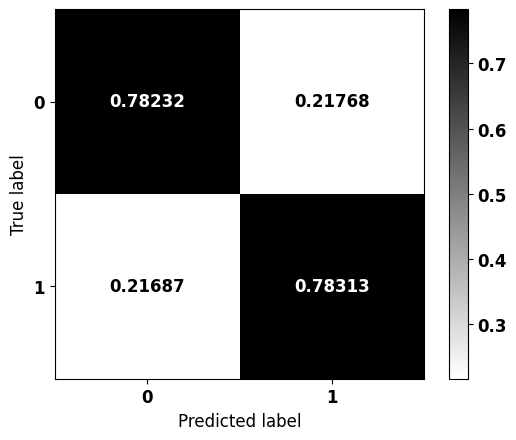


              precision    recall  f1-score   support

           0    0.95868   0.78232   0.86156      8007
           1    0.35872   0.78313   0.49205      1245

    accuracy                        0.78243      9252
   macro avg    0.65870   0.78272   0.67681      9252
weighted avg    0.87794   0.78243   0.81184      9252



In [51]:
# Criação e treinamento do modelo XGBoost
xgb_pulm = XGBClassifier(max_depth=3,
                    scale_pos_weight=7.27,
                    random_state=seed)

xgb_pulm.fit(X_train_pulm, y_train_pulm)

# Matriz de confusão
plot_confusion_matrix(xgb_pulm, X_test_pulm, y_test_pulm)

#### **Optuna**

In [52]:
params = {'n_estimators': 126,
 'max_depth': 4,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 7.256

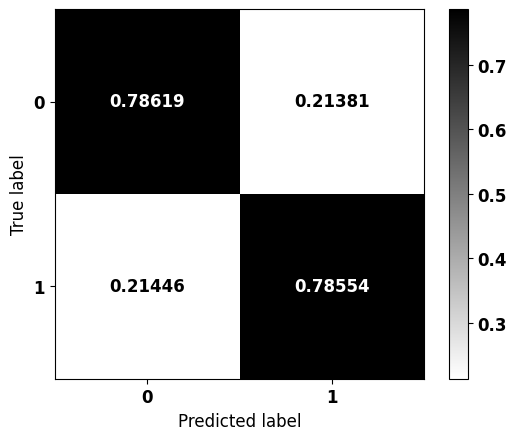


              precision    recall  f1-score   support

           0    0.95931   0.78619   0.86416      8007
           1    0.36357   0.78554   0.49708      1245

    accuracy                        0.78610      9252
   macro avg    0.66144   0.78586   0.68062      9252
weighted avg    0.87914   0.78610   0.81477      9252



In [53]:
# Modelo com os melhores parâmetros
xgb_optuna_pulm = XGBClassifier()
xgb_optuna_pulm.set_params(**params)

xgb_optuna_pulm.fit(X_train_pulm, y_train_pulm)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_pulm, X_test_pulm, y_test_pulm)

### **LightGBM**


#### **Modelo base**

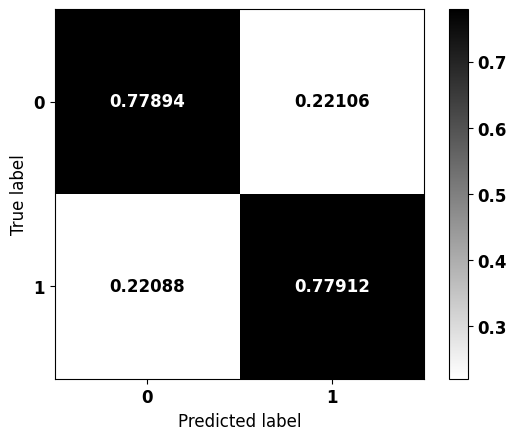


              precision    recall  f1-score   support

           0    0.95777   0.77894   0.85915      8007
           1    0.35401   0.77912   0.48683      1245

    accuracy                        0.77897      9252
   macro avg    0.65589   0.77903   0.67299      9252
weighted avg    0.87653   0.77897   0.80905      9252



In [54]:
# Criação e treinamento do modelo LightGBM
lgbm_pulm = LGBMClassifier(max_depth=4,
                      class_weight={0:1, 1:7.2},
                      random_state=seed,
                      verbose=-1)

lgbm_pulm.fit(X_train_pulm, y_train_pulm)

# Matriz de confusão
plot_confusion_matrix(lgbm_pulm, X_test_pulm, y_test_pulm)

#### **Optuna**

In [55]:
params = {'n_estimators': 112,
 'max_depth': 5,
 'learning_rate': 0.08,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:7.25}

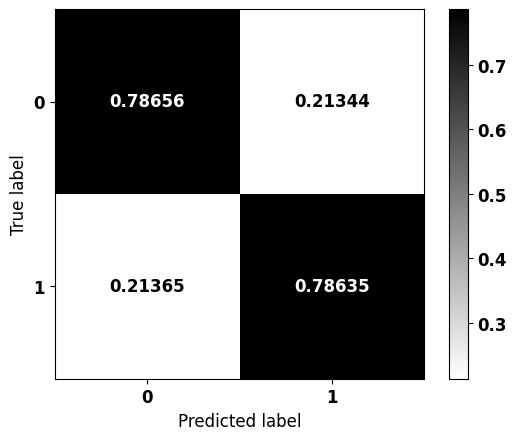


              precision    recall  f1-score   support

           0    0.95948   0.78656   0.86446      8007
           1    0.36421   0.78635   0.49784      1245

    accuracy                        0.78653      9252
   macro avg    0.66184   0.78645   0.68115      9252
weighted avg    0.87937   0.78653   0.81512      9252



In [56]:
# Modelo com os melhores parâmetros
lgbm_optuna_pulm = LGBMClassifier(verbose=-1)
lgbm_optuna_pulm.set_params(**params)

lgbm_optuna_pulm.fit(X_train_pulm, y_train_pulm)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_pulm, X_test_pulm, y_test_pulm)

### **Melhor modelo**

In [57]:
# Melhor modelo
models = [xgb_pulm, xgb_optuna_pulm, lgbm_pulm, lgbm_optuna_pulm]
for i, m in enumerate(models):
    if i == 0:
        best_pulm = m
    else:
        best_score = best_pulm.score(X_test_pulm, y_test_pulm)
        score = m.score(X_test_pulm, y_test_pulm)
        if score > best_score:
            best_pulm = m

print(best_pulm)

LGBMClassifier(class_weight={0: 1, 1: 7.25}, colsample_bytree=0.5,
               learning_rate=0.08, max_depth=5, min_child_weight=6,
               n_estimators=112, random_state=7, verbose=-1)


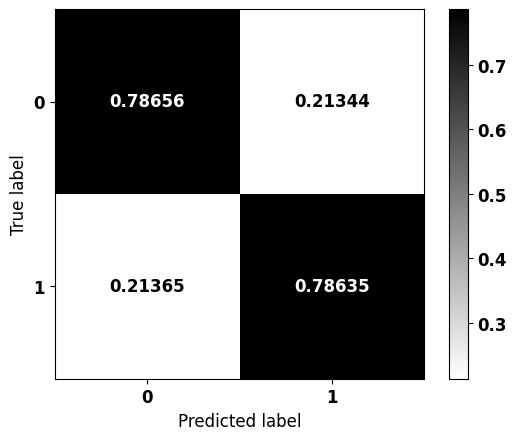


              precision    recall  f1-score   support

           0    0.95948   0.78656   0.86446      8007
           1    0.36421   0.78635   0.49784      1245

    accuracy                        0.78653      9252
   macro avg    0.66184   0.78645   0.68115      9252
weighted avg    0.87937   0.78653   0.81512      9252



In [58]:
# Matriz de confusão
plot_confusion_matrix(best_pulm, X_test_pulm, y_test_pulm)

## **Colo do Útero**

In [59]:
# Leitura dos dados de colo do útero
print(df_colo_utero.shape)
df_colo_utero.head(3)

(21470, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,56,2,3518701,9,2,C530,C53,IB1,G,0,...,7,3518701,1,1.0,1,0,1,1,0,0
1,72,2,3518701,9,1,C539,C53,IIIB,C,0,...,7,3518701,1,2.0,1,0,1,0,0,0
2,63,2,3518701,9,1,C539,C53,IB1,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0


In [60]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_colo_utero, X_test_colo_utero, y_train_colo_utero, y_test_colo_utero, feat_cols, enc, norm = preprocessing(df_colo_utero,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (16102, 23), X_test = (5368, 23)
y_train = (16102,), y_test = (5368,)


### **XGBoost**


#### **Modelo base**

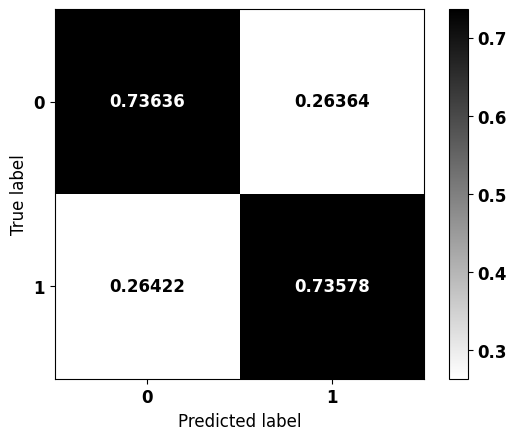


              precision    recall  f1-score   support

           0    0.67796   0.73636   0.70596      2310
           1    0.78699   0.73578   0.76052      3058

    accuracy                        0.73603      5368
   macro avg    0.73247   0.73607   0.73324      5368
weighted avg    0.74007   0.73603   0.73704      5368



In [61]:
# Criação e treinamento do modelo XGBoost
xgb_colo_utero = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.851,
                    random_state=seed)

xgb_colo_utero.fit(X_train_colo_utero, y_train_colo_utero)

# Matriz de confusão
plot_confusion_matrix(xgb_colo_utero, X_test_colo_utero, y_test_colo_utero)

#### **Optuna**

In [62]:
params = {'n_estimators': 120,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 0.8551

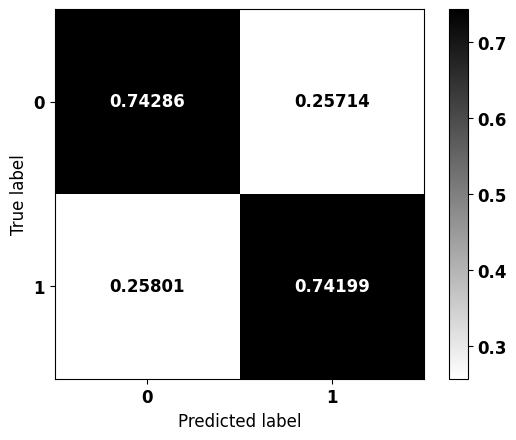


              precision    recall  f1-score   support

           0    0.68503   0.74286   0.71277      2310
           1    0.79253   0.74199   0.76642      3058

    accuracy                        0.74236      5368
   macro avg    0.73878   0.74242   0.73960      5368
weighted avg    0.74627   0.74236   0.74334      5368



In [63]:
# Modelo com os melhores parâmetros
xgb_optuna_colo_utero = XGBClassifier()
xgb_optuna_colo_utero.set_params(**params)

xgb_optuna_colo_utero.fit(X_train_colo_utero, y_train_colo_utero)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna_colo_utero, X_test_colo_utero, y_test_colo_utero)

### **LightGBM**


#### **Modelo base**

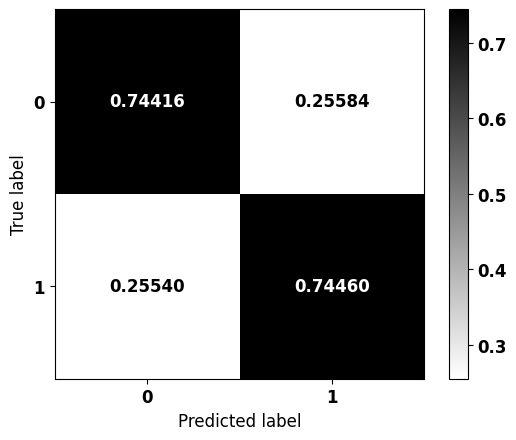


              precision    recall  f1-score   support

           0    0.68760   0.74416   0.71476      2310
           1    0.79393   0.74460   0.76848      3058

    accuracy                        0.74441      5368
   macro avg    0.74077   0.74438   0.74162      5368
weighted avg    0.74817   0.74441   0.74536      5368



In [64]:
# Criação e treinamento do modelo LightGBM
lgbm_colo_utero = LGBMClassifier(max_depth=4,
                      class_weight={0:1.154, 1:1},
                      random_state=seed,
                      importance_type='gain',
                      verbose=-1)

lgbm_colo_utero.fit(X_train_colo_utero, y_train_colo_utero)

# Matriz de confusão
plot_confusion_matrix(lgbm_colo_utero, X_test_colo_utero, y_test_colo_utero)

#### **Optuna**

In [65]:
params = {'n_estimators': 129,
 'max_depth': 4,
 'learning_rate': 0.13,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1.173, 1:1}

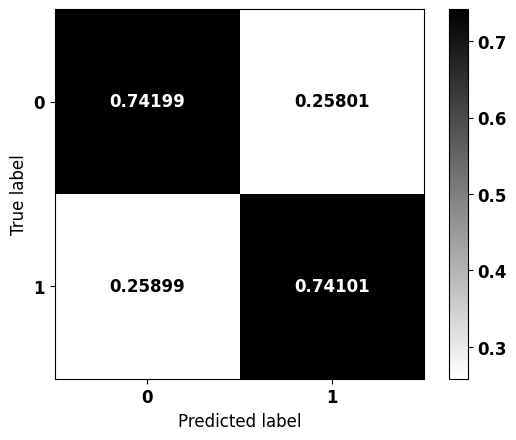


              precision    recall  f1-score   support

           0    0.68396   0.74199   0.71179      2310
           1    0.79175   0.74101   0.76554      3058

    accuracy                        0.74143      5368
   macro avg    0.73786   0.74150   0.73867      5368
weighted avg    0.74537   0.74143   0.74241      5368



In [66]:
# Modelo com os melhores parâmetros
lgbm_optuna_colo_utero = LGBMClassifier(verbose=-1)
lgbm_optuna_colo_utero.set_params(**params)

lgbm_optuna_colo_utero.fit(X_train_colo_utero, y_train_colo_utero)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna_colo_utero, X_test_colo_utero, y_test_colo_utero)

### **Melhor modelo**

In [67]:
# Melhor modelo
models = [xgb_colo_utero, xgb_optuna_colo_utero, lgbm_colo_utero, lgbm_optuna_colo_utero]
for i, m in enumerate(models):
    if i == 0:
        best_colo_utero = m
    else:
        best_score = best_colo_utero.score(X_test_colo_utero, y_test_colo_utero)
        score = m.score(X_test_colo_utero, y_test_colo_utero)
        if score > best_score:
            best_colo_utero = m

print(best_colo_utero)

LGBMClassifier(class_weight={0: 1.154, 1: 1}, importance_type='gain',
               max_depth=4, random_state=7, verbose=-1)


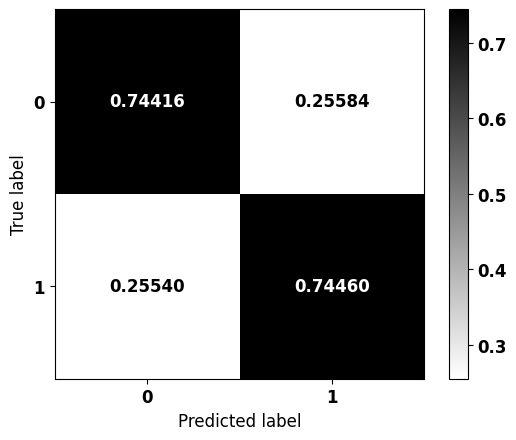


              precision    recall  f1-score   support

           0    0.68760   0.74416   0.71476      2310
           1    0.79393   0.74460   0.76848      3058

    accuracy                        0.74441      5368
   macro avg    0.74077   0.74438   0.74162      5368
weighted avg    0.74817   0.74441   0.74536      5368



In [68]:
# Matriz de confusão
plot_confusion_matrix(best_colo_utero, X_test_colo_utero, y_test_colo_utero)

## **Grade de matrizes de confusão**

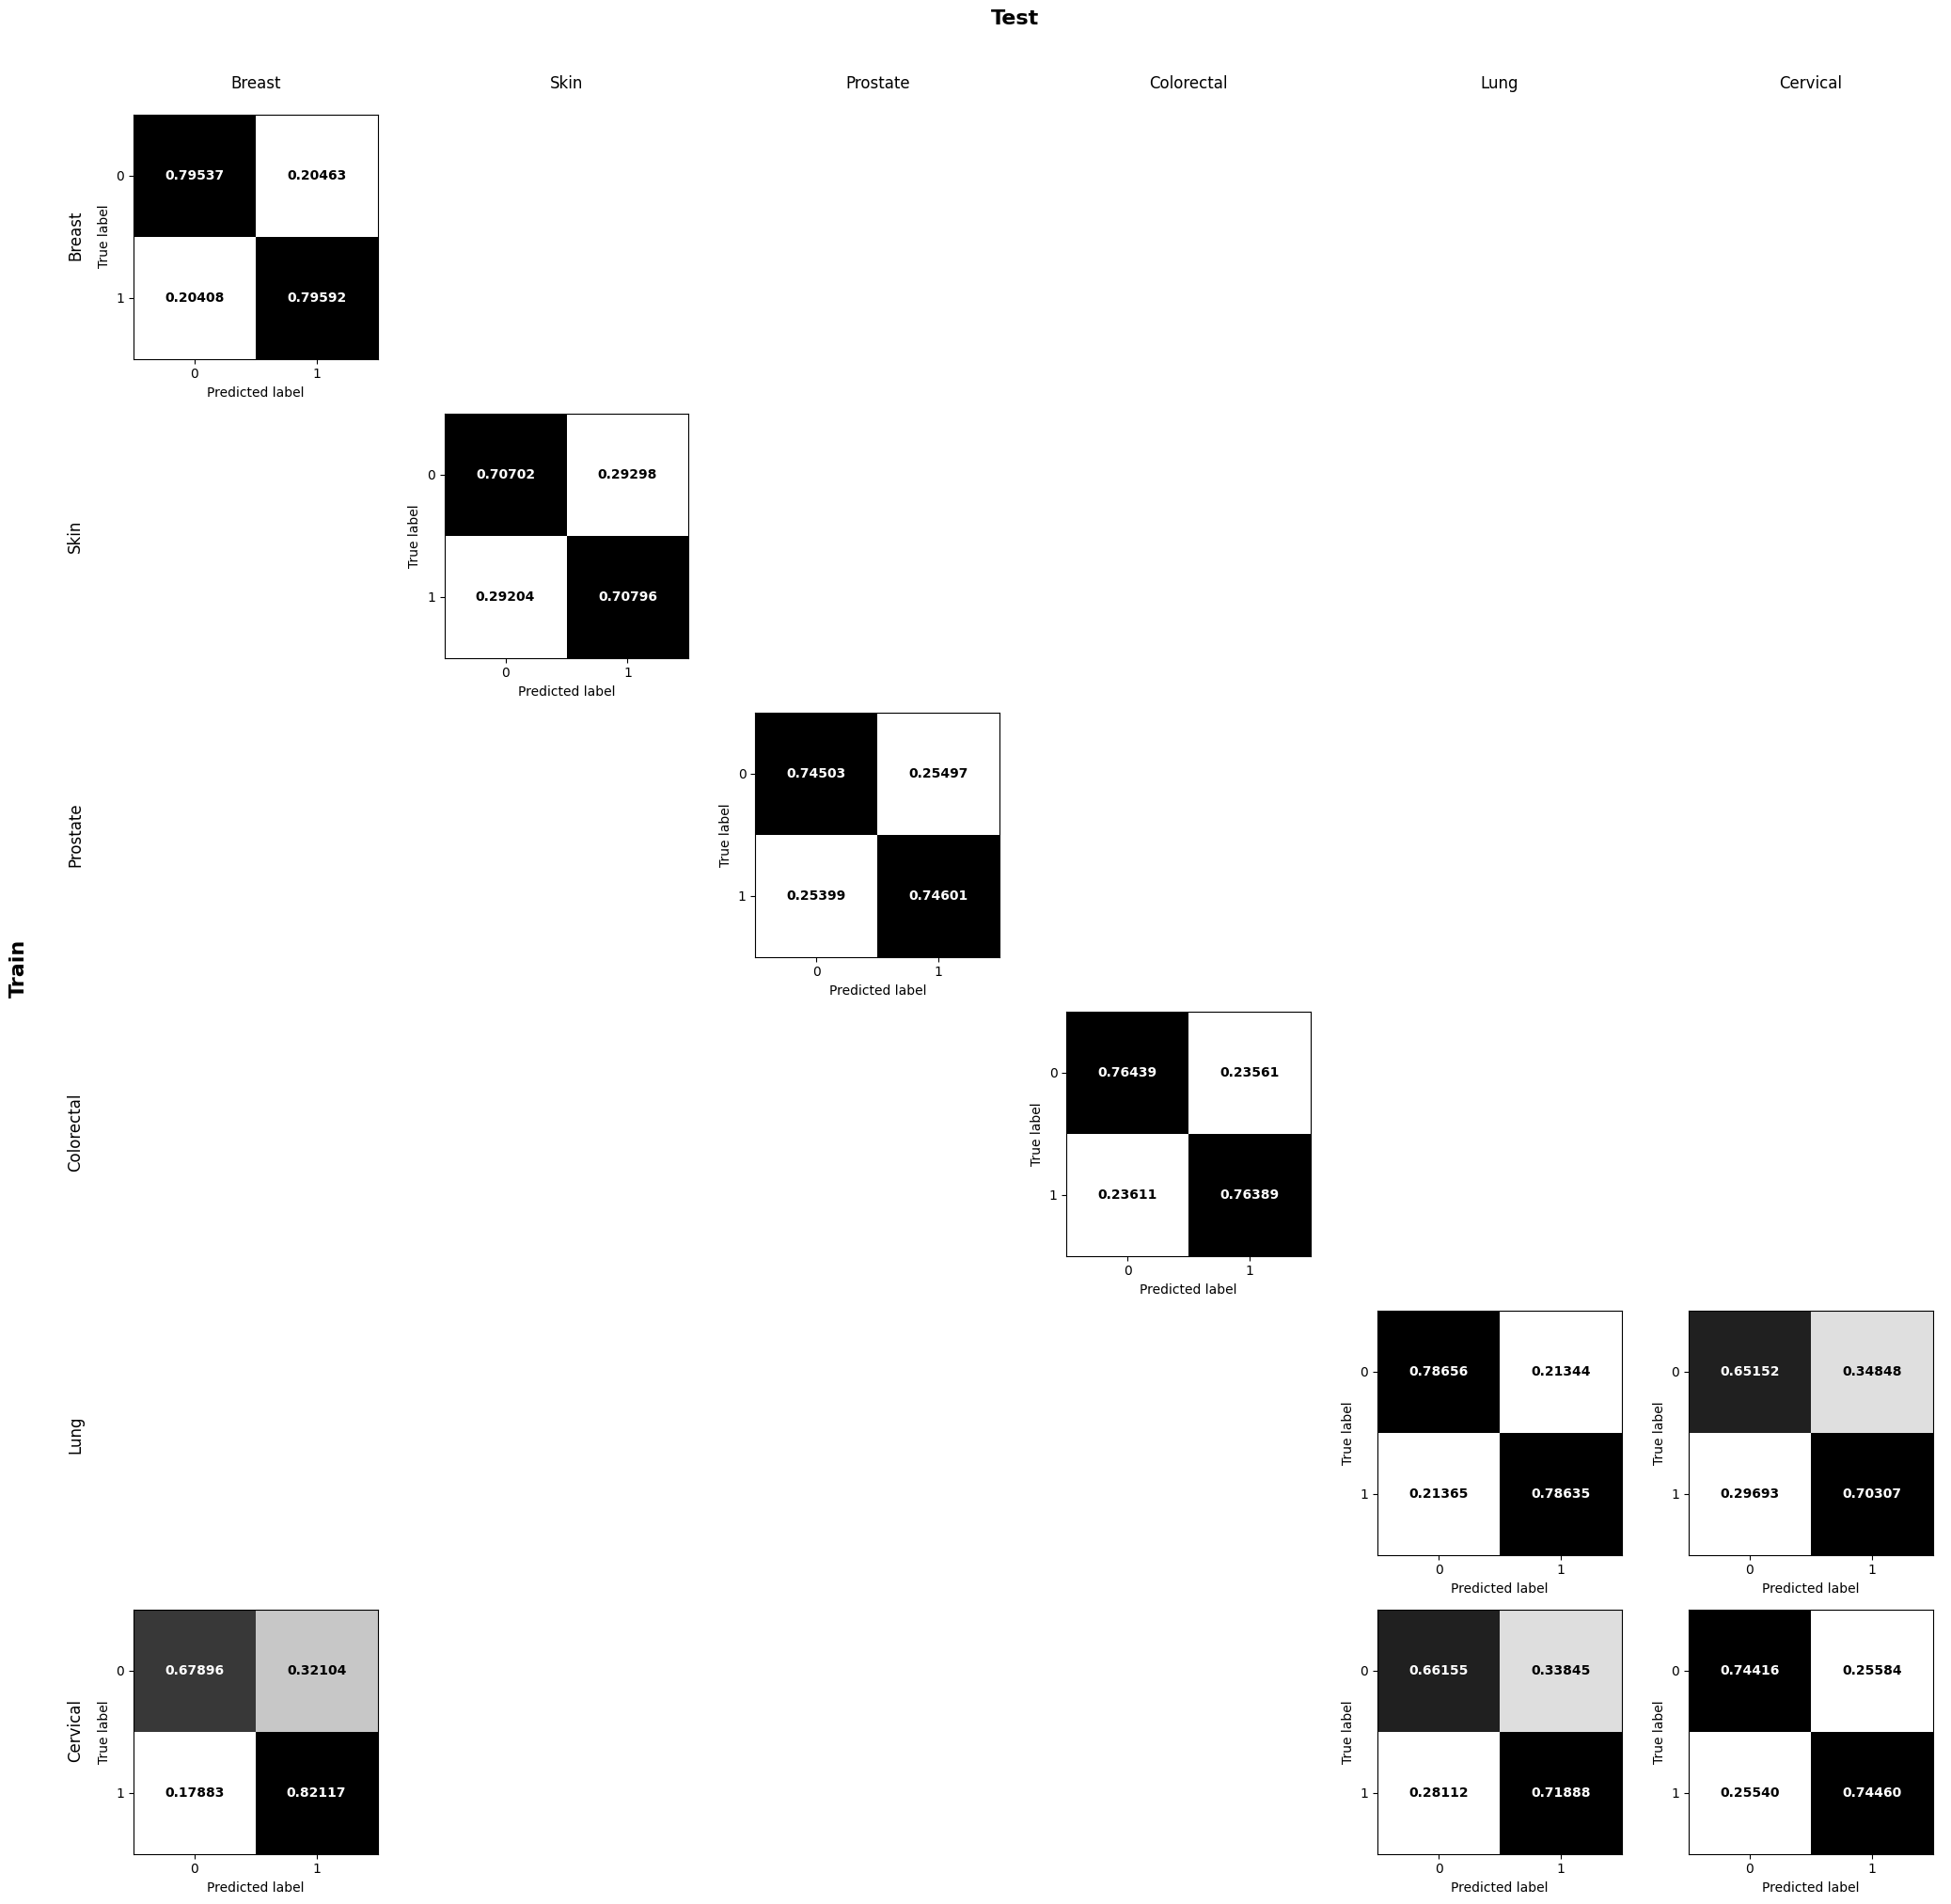

In [69]:
import matplotlib.pyplot as plt

# Títulos gerais
title_general_columns = 'Test'
title_general_rows = 'Train'

# Títulos das colunas e linhas
titles = ['Breast', 'Skin', 'Prostate', 'Colorectal', 'Lung', 'Cervical']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {0: (best_mama, X_test_mama, y_test_mama),
                     7: (best_pele, X_test_pele, y_test_pele),
                     14: (best_prost, X_test_prost, y_test_prost),
                     21: (best_colo, X_test_colo, y_test_colo),
                     28: (best_pulm, X_test_pulm, y_test_pulm),
                     29: (best_pulm, X_test_colo_utero, y_test_colo_utero),
                     30: (best_colo_utero, X_test_mama, y_test_mama),
                     34: (best_colo_utero, X_test_pulm, y_test_pulm),
                     35: (best_colo_utero, X_test_colo_utero, y_test_colo_utero)}

position = [0.89, 0.73, 0.571, 0.413, 0.252, 0.095]  # Ajuste as posições conforme necessário

# Configuração da figura com 6 linhas e 6 colunas
fig, axes = plt.subplots(6, 6, figsize=(20, 20))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0], positions_to_fill[i][1],
                                 positions_to_fill[i][2], ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(6):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(6):
    fig.text(0, position[row_idx], titles[row_idx], va='center',
             ha='center', rotation='vertical', fontsize=12)  # Ajuste o valor de x conforme necessário

# Adiciona título geral para as colunas
fig.suptitle(title_general_columns, fontsize=16, y=1.01, weight='bold')

# Adiciona título geral para as linhas
fig.text(-0.03, 0.5, title_general_rows, va='center', ha='center',
         rotation='vertical', fontsize=16, weight='bold')  # Ajuste o valor de x conforme necessário

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/incid.eps', bbox_inches='tight')

# **Conexões**

In [ ]:
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino
!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste

In [ ]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(302582, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.900006,1.028664,-1.095067,-0.714301,0.958036,1.605010,-1.664088,-0.567847,0.737288,-0.078540,...,0.933829,0.327366,0.896330,-1.117133,0.396181,0.154944,0.964441,-0.475073,Colorretal,0
1,2.017011,0.078323,0.709472,1.270371,-0.915765,-1.584428,0.545300,1.015205,-1.536653,0.848079,...,-1.183185,-0.851058,-1.799187,0.743452,0.599581,-0.940442,-1.048322,-0.514970,Mama,1
2,0.474908,1.091681,-0.572151,1.167751,-0.344597,1.142798,0.315561,-0.242155,-0.156064,-0.038330,...,-1.672914,-0.765173,0.926783,-0.202185,0.393904,-0.406625,-0.776427,-0.218179,Pele,1


In [ ]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(100864, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.366829,-0.972134,1.141405,1.343451,0.958036,-0.047542,0.60093,-0.567847,0.737288,-0.078540,...,-1.734289,1.587885,0.660606,-1.716753,0.396181,1.180668,-1.036870,-0.475073,Colorretal,1
1,-0.166349,-0.972134,-0.649610,1.343451,0.958036,-0.873817,0.60093,1.761039,0.737288,-0.078540,...,-0.209650,1.767959,-0.282288,0.900562,-0.968850,0.154944,-1.036870,-0.475073,Colorretal,1
2,-0.623264,0.078323,-0.758504,1.270371,-0.915765,-1.584428,0.54530,1.015205,-1.536653,0.848079,...,-0.446767,-0.851058,-0.888302,0.743452,-0.803767,0.967430,-1.048322,-0.514970,Mama,1


In [ ]:
df_incid_treino.TOPOGRUP.value_counts()

TOPOGRUP
Mama             78399
Pele             75662
Próstata         62583
Colorretal       42083
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
um = ['Pulmão', 'Colo de Útero']
dois = ['Colo de Útero', 'Mama', 'Pulmão']

df1_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(um)]
df1_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(um)]

df2_treino = df_incid_treino[df_incid_treino.TOPOGRUP.isin(dois)]
df2_teste = df_incid_teste[df_incid_teste.TOPOGRUP.isin(dois)]

df1_treino.shape, df1_teste.shape, df2_treino.shape, df2_teste.shape

((43855, 25), (14620, 25), (122254, 25), (40753, 25))

In [ ]:
# DFs de teste para cada tipo
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Mama']
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pulmão']
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colo de Útero']

mama_teste.shape, pulm_teste.shape, colo_utero_teste.shape

((26133, 25), (9252, 25), (5368, 25))

In [ ]:
from sklearn.utils import shuffle

df1_treino = shuffle(df1_treino, random_state=seed)
df1_teste = shuffle(df1_teste, random_state=seed)

df2_treino = shuffle(df2_treino, random_state=seed)
df2_teste = shuffle(df2_teste, random_state=seed)

## **Pulmão com Colo de Útero**

In [ ]:
df1_treino.TOPOGRUP.value_counts()

TOPOGRUP
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df1_treino['TOPOGRUP'] = oe.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = oe.transform(df1_teste[['TOPOGRUP']])

ss = StandardScaler()
df1_treino['TOPOGRUP'] = ss.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = ss.transform(df1_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df1_treino.drop(columns=list_drop).copy()
y_train = df1_treino.sobrevida_3anos.copy()

# Teste
X_test = df1_teste.drop(columns=list_drop).copy()
y_test = df1_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((43855, 24), (43855,), (14620, 24), (14620,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

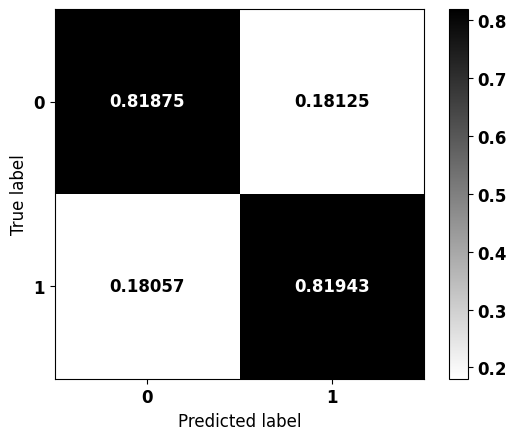


              precision    recall  f1-score   support

           0    0.91576   0.81875   0.86454     10317
           1    0.65345   0.81943   0.72709      4303

    accuracy                        0.81895     14620
   macro avg    0.78461   0.81909   0.79581     14620
weighted avg    0.83856   0.81895   0.82408     14620



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=2.415,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 143,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 2.277

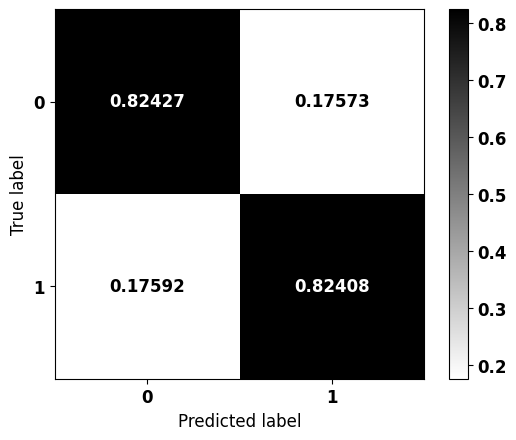


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

### **LightGBM**


#### **Modelo base**

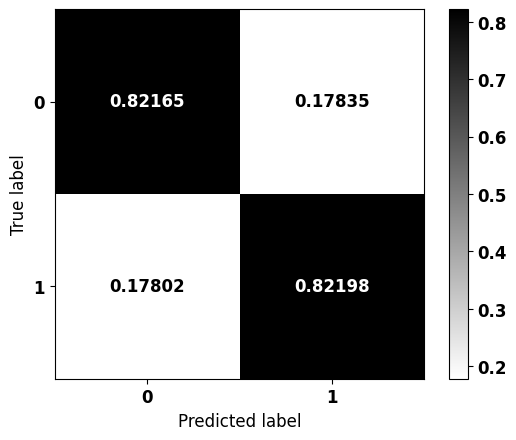


              precision    recall  f1-score   support

           0    0.91713   0.82165   0.86677     10317
           1    0.65780   0.82198   0.73079      4303

    accuracy                        0.82175     14620
   macro avg    0.78746   0.82182   0.79878     14620
weighted avg    0.84080   0.82175   0.82675     14620



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:2.267},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 102,
 'max_depth': 6,
 'learning_rate': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.257}

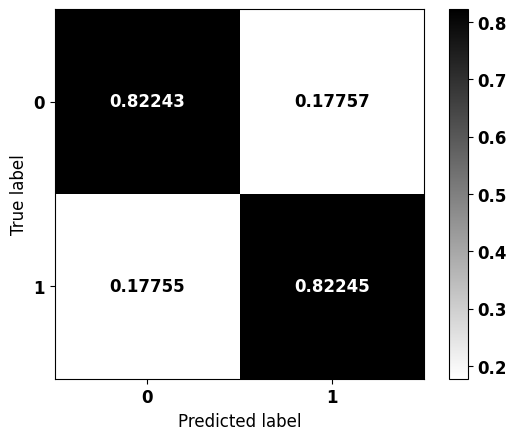


              precision    recall  f1-score   support

           0    0.91740   0.82243   0.86732     10317
           1    0.65891   0.82245   0.73165      4303

    accuracy                        0.82244     14620
   macro avg    0.78815   0.82244   0.79949     14620
weighted avg    0.84132   0.82244   0.82739     14620



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=143, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


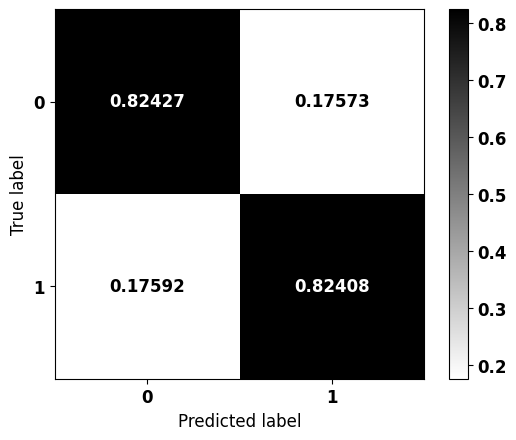


              precision    recall  f1-score   support

           0    0.91826   0.82427   0.86873     10317
           1    0.66169   0.82408   0.73401      4303

    accuracy                        0.82421     14620
   macro avg    0.78997   0.82417   0.80137     14620
weighted avg    0.84275   0.82421   0.82908     14620



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

In [ ]:
# Pulmão
X_test_pulm_c = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm_c = pulm_teste.sobrevida_3anos.copy()

X_test_pulm_c['TOPOGRUP'] = oe.transform(X_test_pulm_c[['TOPOGRUP']])
X_test_pulm_c['TOPOGRUP'] = ss.transform(X_test_pulm_c[['TOPOGRUP']])

# Colo de Útero
X_test_colo_utero_c = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero_c = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero_c['TOPOGRUP'] = oe.transform(X_test_colo_utero_c[['TOPOGRUP']])
X_test_colo_utero_c['TOPOGRUP'] = ss.transform(X_test_colo_utero_c[['TOPOGRUP']])

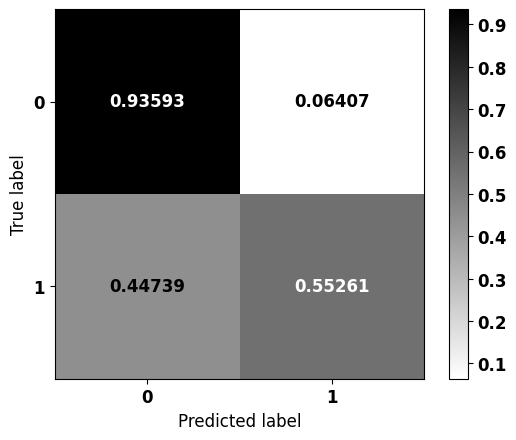


              precision    recall  f1-score   support

           0    0.93082   0.93593   0.93337      8007
           1    0.57286   0.55261   0.56255      1245

    accuracy                        0.88435      9252
   macro avg    0.75184   0.74427   0.74796      9252
weighted avg    0.88265   0.88435   0.88347      9252



In [ ]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm_c, y_test_pulm_c)

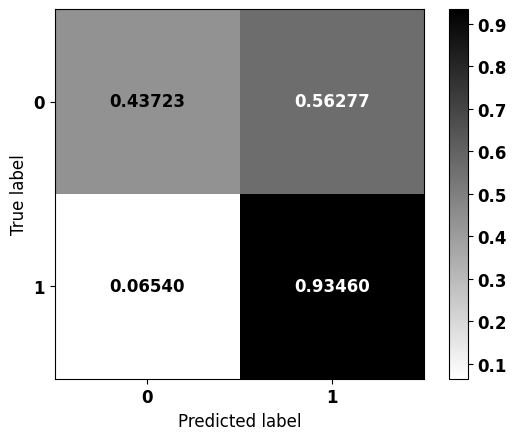


              precision    recall  f1-score   support

           0    0.83471   0.43723   0.57386      2310
           1    0.68735   0.93460   0.79213      3058

    accuracy                        0.72057      5368
   macro avg    0.76103   0.68591   0.68300      5368
weighted avg    0.75076   0.72057   0.69820      5368



In [ ]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero_c, y_test_colo_utero_c)

### **Grade de matrizes de confusão**

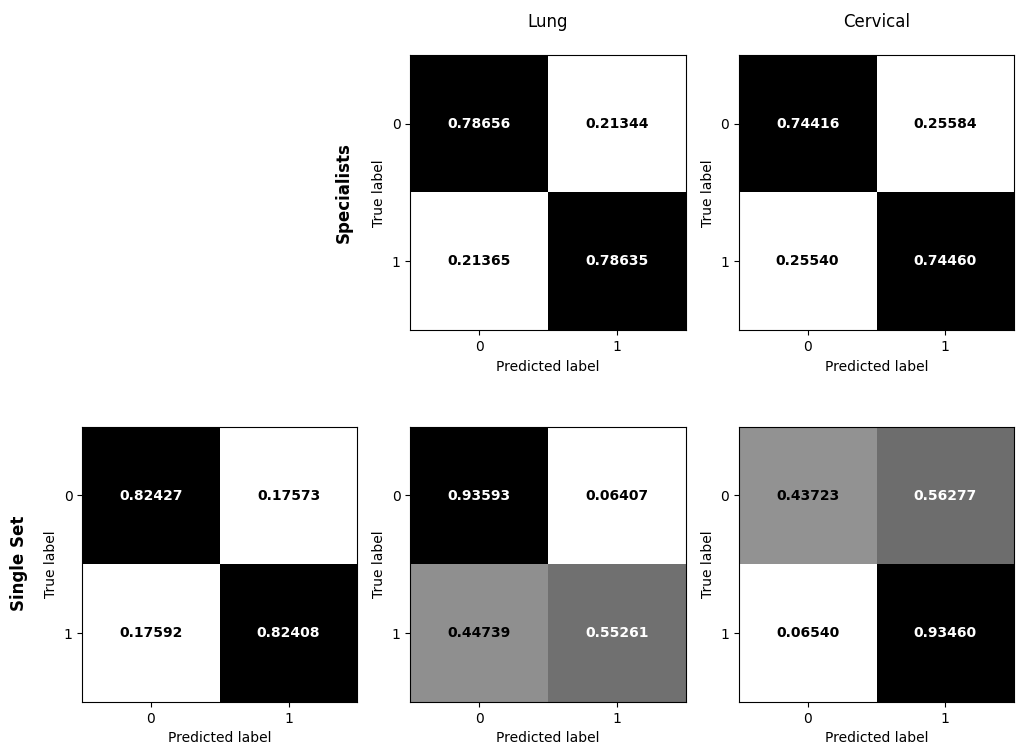

In [ ]:
import seaborn as sns

# Títulos das colunas
titles = ['', 'Lung', 'Cervical']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_pulm, X_test_pulm, y_test_pulm),
                     2: (best_colo_utero, X_test_colo_utero, y_test_colo_utero),
                     3: (best, X_test, y_test),
                     4: (best, X_test_pulm_c, y_test_pulm_c),
                     5: (best, X_test_colo_utero_c, y_test_colo_utero_c)}

position = [0.733, 0.27] # 0.88 - (row_idx / 6)

# Configuração da figura com 2 linhas e 3 colunas
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(3):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.315, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/pulm_colo_utero.eps', bbox_inches='tight')

## **Colo de Útero com Mama e Pulmão**

In [ ]:
df2_treino.TOPOGRUP.value_counts()

TOPOGRUP
Mama             78399
Pulmão           27753
Colo de Útero    16102
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df2_treino['TOPOGRUP'] = oe.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = oe.transform(df2_teste[['TOPOGRUP']])

ss = StandardScaler()
df2_treino['TOPOGRUP'] = ss.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = ss.transform(df2_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df2_treino.drop(columns=list_drop).copy()
y_train = df2_treino.sobrevida_3anos.copy()

# Teste
X_test = df2_teste.drop(columns=list_drop).copy()
y_test = df2_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((122254, 24), (122254,), (40753, 24), (40753,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

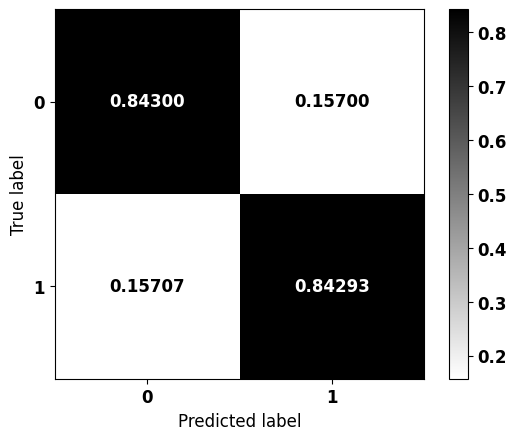


              precision    recall  f1-score   support

           0    0.76707   0.84300   0.80325     15497
           1    0.89744   0.84293   0.86933     25256

    accuracy                        0.84296     40753
   macro avg    0.83225   0.84297   0.83629     40753
weighted avg    0.84786   0.84296   0.84420     40753



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=6,
                    scale_pos_weight=0.566,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 141,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 0.572

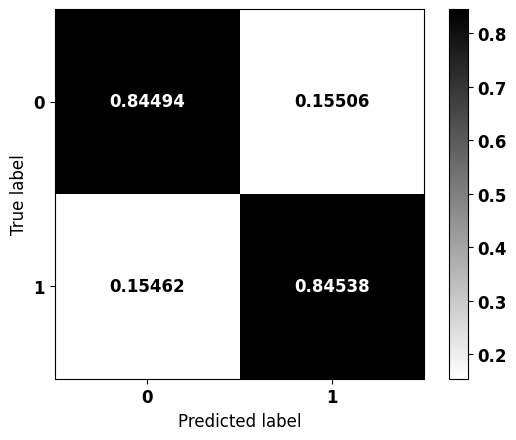


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

### **LightGBM**


#### **Modelo base**

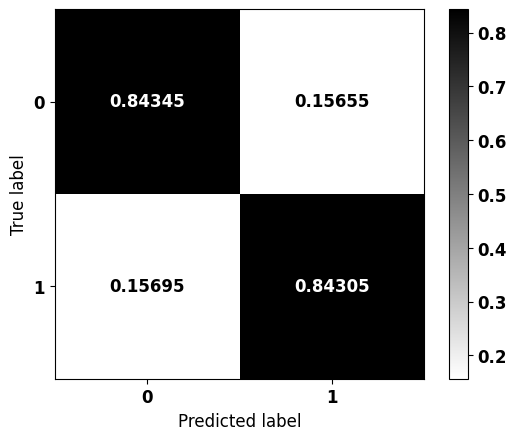


              precision    recall  f1-score   support

           0    0.76730   0.84345   0.80358     15497
           1    0.89771   0.84305   0.86952     25256

    accuracy                        0.84320     40753
   macro avg    0.83251   0.84325   0.83655     40753
weighted avg    0.84812   0.84320   0.84445     40753



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.665, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 135,
 'max_depth': 9,
 'learning_rate': 0.15,
 'min_child_weight': 6,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1.732, 1:1}

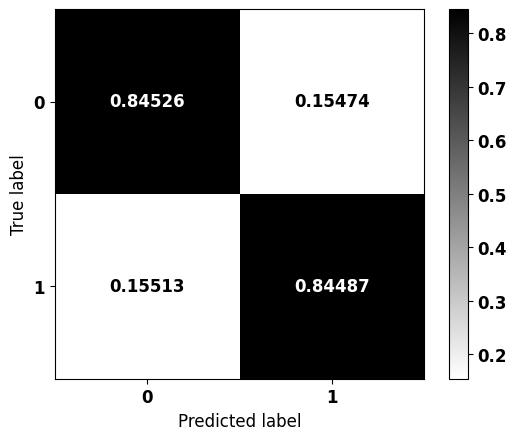


              precision    recall  f1-score   support

           0    0.76976   0.84526   0.80575     15497
           1    0.89897   0.84487   0.87108     25256

    accuracy                        0.84502     40753
   macro avg    0.83437   0.84506   0.83841     40753
weighted avg    0.84984   0.84502   0.84624     40753



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=141, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


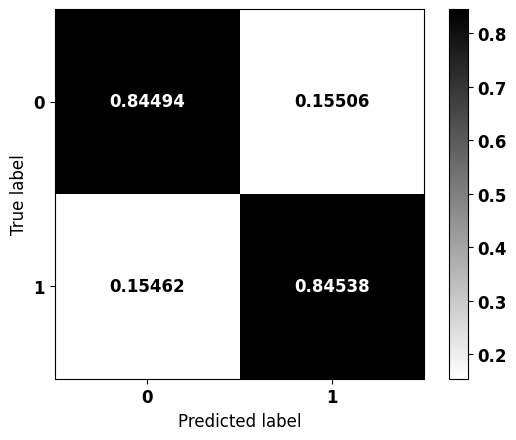


              precision    recall  f1-score   support

           0    0.77028   0.84494   0.80588     15497
           1    0.89884   0.84538   0.87129     25256

    accuracy                        0.84521     40753
   macro avg    0.83456   0.84516   0.83859     40753
weighted avg    0.84995   0.84521   0.84642     40753



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

In [ ]:
# Colo de Útero
X_test_colo_utero_c = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero_c = colo_utero_teste.sobrevida_3anos.copy()

X_test_colo_utero_c['TOPOGRUP'] = oe.transform(X_test_colo_utero_c[['TOPOGRUP']])
X_test_colo_utero_c['TOPOGRUP'] = ss.transform(X_test_colo_utero_c[['TOPOGRUP']])

# Mama
X_test_mama_c = mama_teste.drop(columns=list_drop).copy()
y_test_mama_c = mama_teste.sobrevida_3anos.copy()

X_test_mama_c['TOPOGRUP'] = oe.transform(X_test_mama_c[['TOPOGRUP']])
X_test_mama_c['TOPOGRUP'] = ss.transform(X_test_mama_c[['TOPOGRUP']])

# Pulmão
X_test_pulm_c = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm_c = pulm_teste.sobrevida_3anos.copy()

X_test_pulm_c['TOPOGRUP'] = oe.transform(X_test_pulm_c[['TOPOGRUP']])
X_test_pulm_c['TOPOGRUP'] = ss.transform(X_test_pulm_c[['TOPOGRUP']])

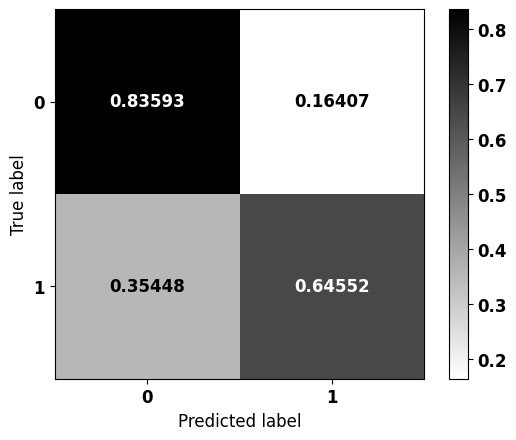


              precision    recall  f1-score   support

           0    0.64046   0.83593   0.72526      2310
           1    0.83893   0.64552   0.72962      3058

    accuracy                        0.72746      5368
   macro avg    0.73970   0.74073   0.72744      5368
weighted avg    0.75352   0.72746   0.72775      5368



In [ ]:
# Colo de Útero
plot_confusion_matrix(best, X_test_colo_utero_c, y_test_colo_utero_c)

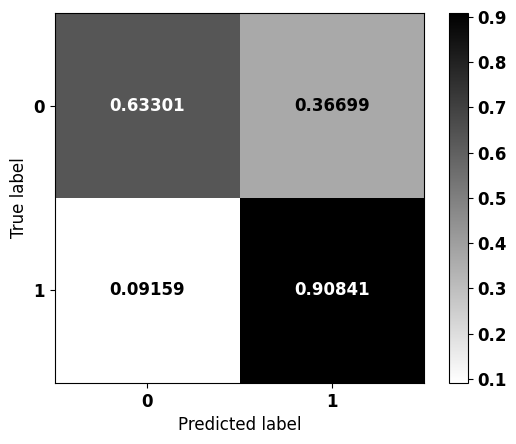


              precision    recall  f1-score   support

           0    0.63082   0.63301   0.63191      5180
           1    0.90920   0.90841   0.90880     20953

    accuracy                        0.85382     26133
   macro avg    0.77001   0.77071   0.77036     26133
weighted avg    0.85402   0.85382   0.85392     26133



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama_c, y_test_mama_c)

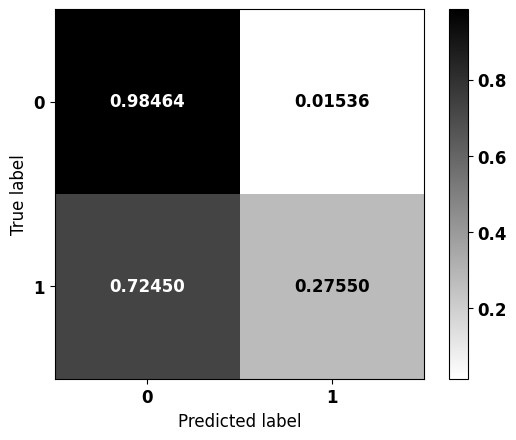


              precision    recall  f1-score   support

           0    0.89734   0.98464   0.93896      8007
           1    0.73605   0.27550   0.40094      1245

    accuracy                        0.88921      9252
   macro avg    0.81669   0.63007   0.66995      9252
weighted avg    0.87563   0.88921   0.86656      9252



In [ ]:
# Pulmão
plot_confusion_matrix(best, X_test_pulm_c, y_test_pulm_c)

### **Grade de matrizes de confusão**

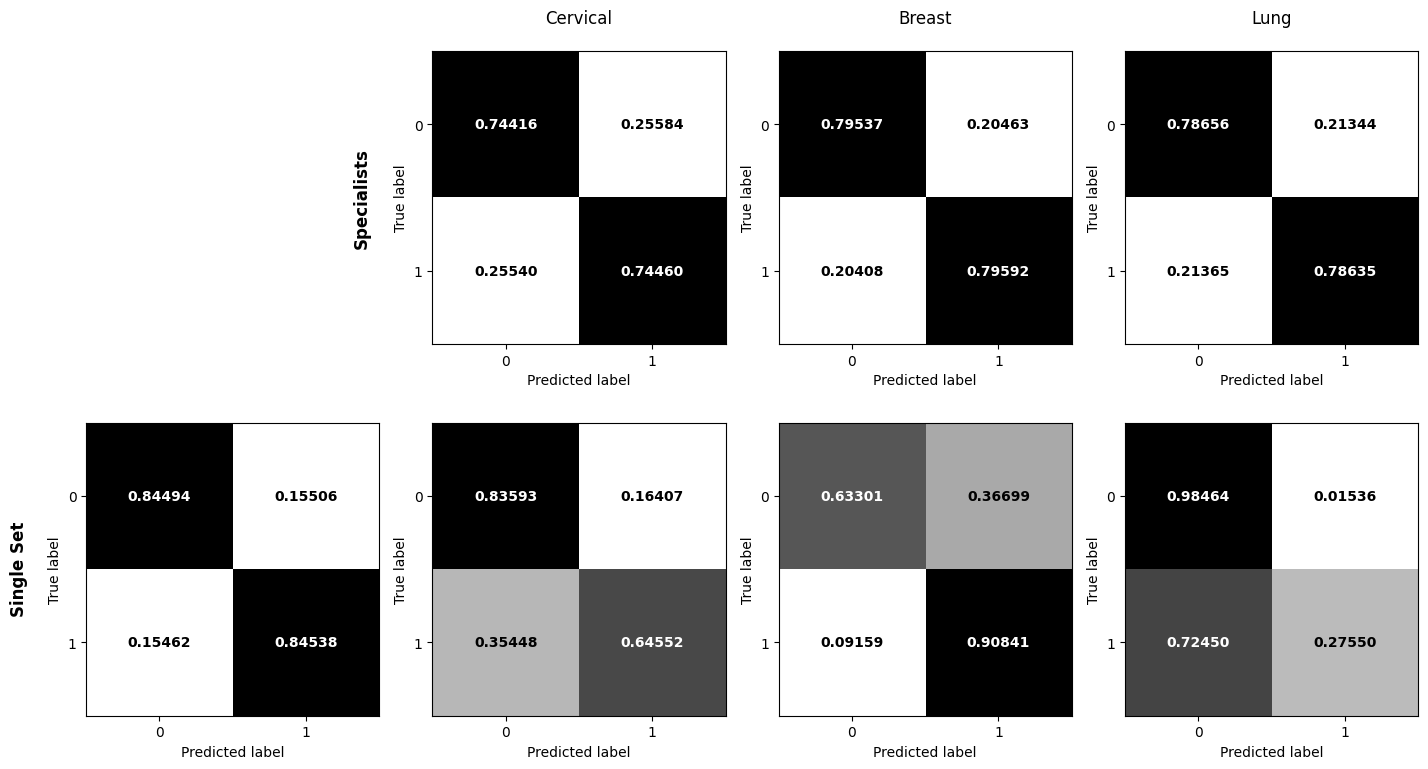

In [ ]:
# Títulos das colunas
titles = ['', 'Cervical', 'Breast', 'Lung']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_colo_utero, X_test_colo_utero, y_test_colo_utero),
                     2: (best_mama, X_test_mama, y_test_mama),
                     3: (best_pulm, X_test_pulm, y_test_pulm),
                     4: (best, X_test, y_test),
                     5: (best, X_test_colo_utero_c, y_test_colo_utero_c),
                     6: (best, X_test_mama_c, y_test_mama_c),
                     7: (best, X_test_pulm_c, y_test_pulm_c)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(4):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.235, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/colo_utero_mama_pulm.eps', bbox_inches='tight')

# **Juntos**

In [ ]:
%%capture

!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino

In [ ]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(302582, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.900006,1.028664,-1.095067,-0.714301,0.958036,1.605010,-1.664088,-0.567847,0.737288,-0.078540,...,0.933829,0.327366,0.896330,-1.117133,0.396181,0.154944,0.964441,-0.475073,Colorretal,0
1,2.017011,0.078323,0.709472,1.270371,-0.915765,-1.584428,0.545300,1.015205,-1.536653,0.848079,...,-1.183185,-0.851058,-1.799187,0.743452,0.599581,-0.940442,-1.048322,-0.514970,Mama,1
2,0.474908,1.091681,-0.572151,1.167751,-0.344597,1.142798,0.315561,-0.242155,-0.156064,-0.038330,...,-1.672914,-0.765173,0.926783,-0.202185,0.393904,-0.406625,-0.776427,-0.218179,Pele,1


In [ ]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(100864, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.366829,-0.972134,1.141405,1.343451,0.958036,-0.047542,0.60093,-0.567847,0.737288,-0.078540,...,-1.734289,1.587885,0.660606,-1.716753,0.396181,1.180668,-1.036870,-0.475073,Colorretal,1
1,-0.166349,-0.972134,-0.649610,1.343451,0.958036,-0.873817,0.60093,1.761039,0.737288,-0.078540,...,-0.209650,1.767959,-0.282288,0.900562,-0.968850,0.154944,-1.036870,-0.475073,Colorretal,1
2,-0.623264,0.078323,-0.758504,1.270371,-0.915765,-1.584428,0.54530,1.015205,-1.536653,0.848079,...,-0.446767,-0.851058,-0.888302,0.743452,-0.803767,0.967430,-1.048322,-0.514970,Mama,1


In [ ]:
# DFs de teste para cada tipo
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colo de Útero']
colo_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colorretal']
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Mama']
pele_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pele']
prost_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Próstata']
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pulmão']

colo_utero_teste.shape, colo_teste.shape, mama_teste.shape, pele_teste.shape, prost_teste.shape, pulm_teste.shape

((5368, 25), (14028, 25), (26133, 25), (25221, 25), (20862, 25), (9252, 25))

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_incid_treino['TOPOGRUP'] = oe.fit_transform(df_incid_treino[['TOPOGRUP']])
df_incid_teste['TOPOGRUP'] = oe.transform(df_incid_teste[['TOPOGRUP']])

ss = StandardScaler()
df_incid_treino['TOPOGRUP'] = ss.fit_transform(df_incid_treino[['TOPOGRUP']])
df_incid_teste['TOPOGRUP'] = ss.transform(df_incid_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_incid_treino.drop(columns=list_drop).copy()
y_train = df_incid_treino.sobrevida_3anos.copy()

# Teste
X_test = df_incid_teste.drop(columns=list_drop).copy()
y_test = df_incid_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((302582, 24), (302582,), (100864, 24), (100864,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

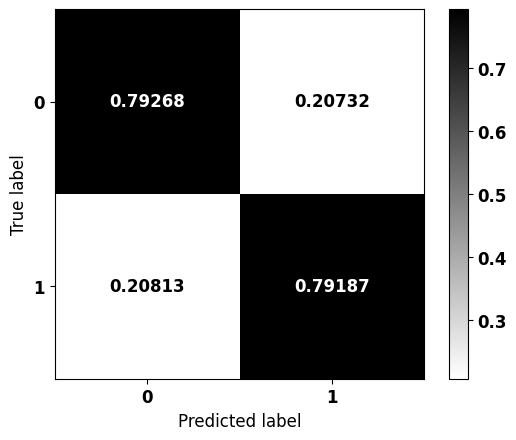


              precision    recall  f1-score   support

           0    0.62757   0.79268   0.70053     30938
           1    0.89619   0.79187   0.84080     69926

    accuracy                        0.79212    100864
   macro avg    0.76188   0.79227   0.77066    100864
weighted avg    0.81379   0.79212   0.79778    100864



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=7,
                    scale_pos_weight=0.368,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 136,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['scale_pos_weight'] = 0.3677

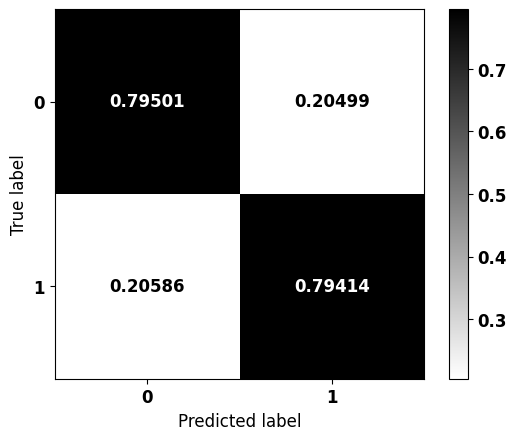


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

### **LightGBM**


#### **Modelo base**

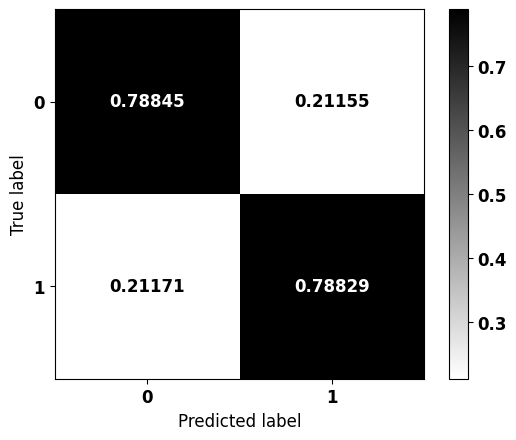


              precision    recall  f1-score   support

           0    0.62232   0.78845   0.69560     30938
           1    0.89387   0.78829   0.83776     69926

    accuracy                        0.78834    100864
   macro avg    0.75809   0.78837   0.76668    100864
weighted avg    0.81057   0.78834   0.79416    100864



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:2.585, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 150,
 'max_depth': 9,
 'learning_rate': 0.19,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['class_weight'] = {0:2.659, 1:1}

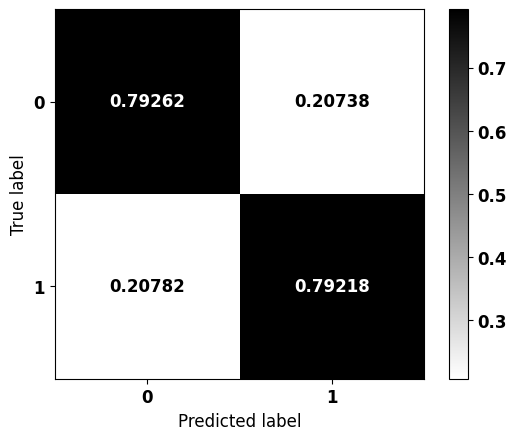


              precision    recall  f1-score   support

           0    0.62790   0.79262   0.70071     30938
           1    0.89620   0.79218   0.84099     69926

    accuracy                        0.79231    100864
   macro avg    0.76205   0.79240   0.77085    100864
weighted avg    0.81390   0.79231   0.79796    100864



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=136, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


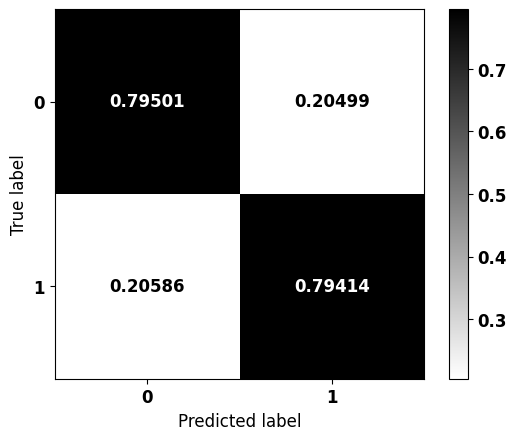


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

In [ ]:
dfs = [colo_utero_teste, colo_teste, mama_teste, pele_teste, prost_teste, pulm_teste]

for df in dfs:
    df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

<ipython-input-327-927801ca41a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
<ipython-input-327-927801ca41a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])
<ipython-input-327-927801ca41a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

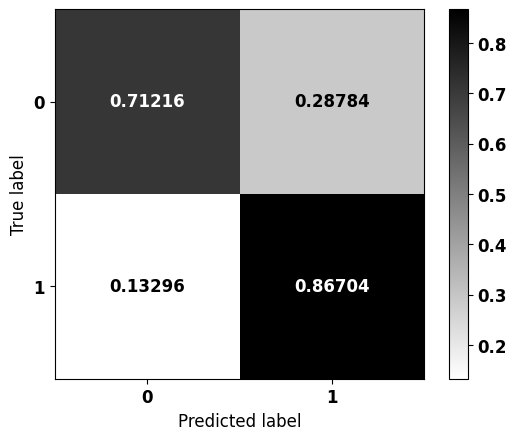


              precision    recall  f1-score   support

           0    0.56973   0.71216   0.63303      5180
           1    0.92415   0.86704   0.89468     20953

    accuracy                        0.83634     26133
   macro avg    0.74694   0.78960   0.76386     26133
weighted avg    0.85390   0.83634   0.84282     26133



In [ ]:
# Mama
X_test_mama_j = mama_teste.drop(columns=list_drop).copy()
y_test_mama_j = mama_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_mama_j, y_test_mama_j)

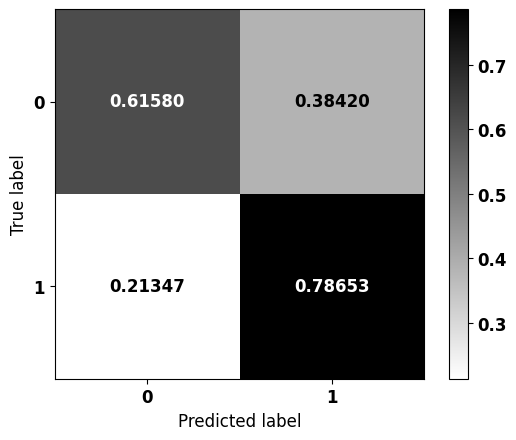


              precision    recall  f1-score   support

           0    0.46274   0.61580   0.52841      5799
           1    0.87271   0.78653   0.82738     19422

    accuracy                        0.74727     25221
   macro avg    0.66773   0.70116   0.67790     25221
weighted avg    0.77845   0.74727   0.75864     25221



In [ ]:
# Pele
X_test_pele_j = pele_teste.drop(columns=list_drop).copy()
y_test_pele_j = pele_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pele_j, y_test_pele_j)

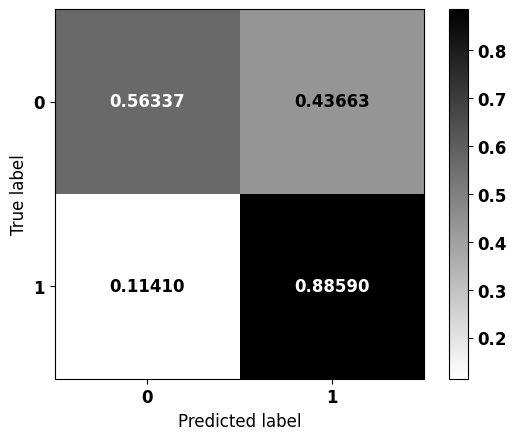


              precision    recall  f1-score   support

           0    0.48742   0.56337   0.52265      3369
           1    0.91331   0.88590   0.89939     17493

    accuracy                        0.83381     20862
   macro avg    0.70036   0.72463   0.71102     20862
weighted avg    0.84453   0.83381   0.83855     20862



In [ ]:
# Próstata
X_test_prost_j = prost_teste.drop(columns=list_drop).copy()
y_test_prost_j = prost_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_prost_j, y_test_prost_j)

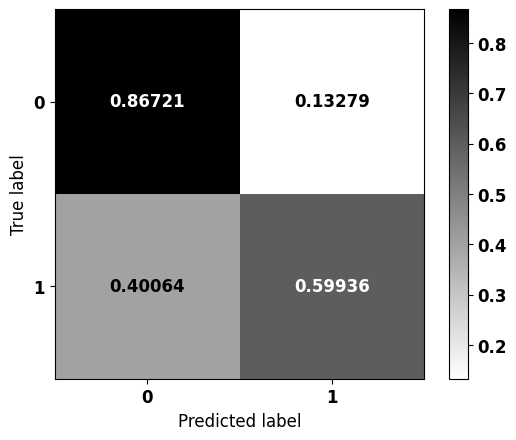


              precision    recall  f1-score   support

           0    0.63648   0.86721   0.73414      6273
           1    0.84802   0.59936   0.70233      7755

    accuracy                        0.71913     14028
   macro avg    0.74225   0.73328   0.71824     14028
weighted avg    0.75342   0.71913   0.71655     14028



In [ ]:
# Colorretal
X_test_colo_j = colo_teste.drop(columns=list_drop).copy()
y_test_colo_j = colo_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo_j, y_test_colo_j)

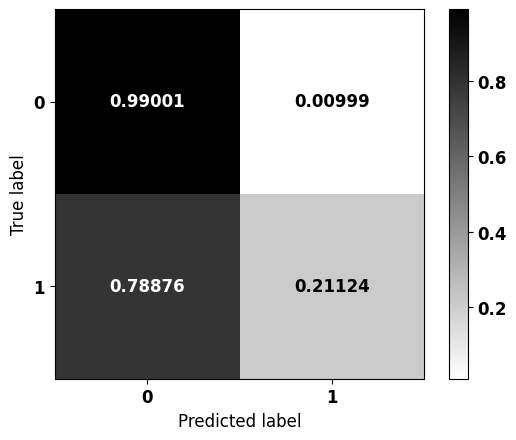


              precision    recall  f1-score   support

           0    0.88977   0.99001   0.93722      8007
           1    0.76676   0.21124   0.33123      1245

    accuracy                        0.88521      9252
   macro avg    0.82827   0.60063   0.63423      9252
weighted avg    0.87322   0.88521   0.85567      9252



In [ ]:
# Pulmão
X_test_pulm_j = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm_j = pulm_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pulm_j, y_test_pulm_j)

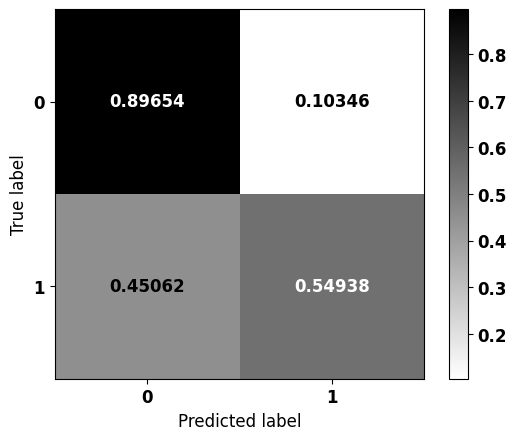


              precision    recall  f1-score   support

           0    0.60046   0.89654   0.71922      2310
           1    0.87546   0.54938   0.67511      3058

    accuracy                        0.69877      5368
   macro avg    0.73796   0.72296   0.69716      5368
weighted avg    0.75712   0.69877   0.69409      5368



In [ ]:
# Colo de Útero
X_test_colo_utero_j = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero_j = colo_utero_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo_utero_j, y_test_colo_utero_j)

### **Grade de matrizes de confusão**

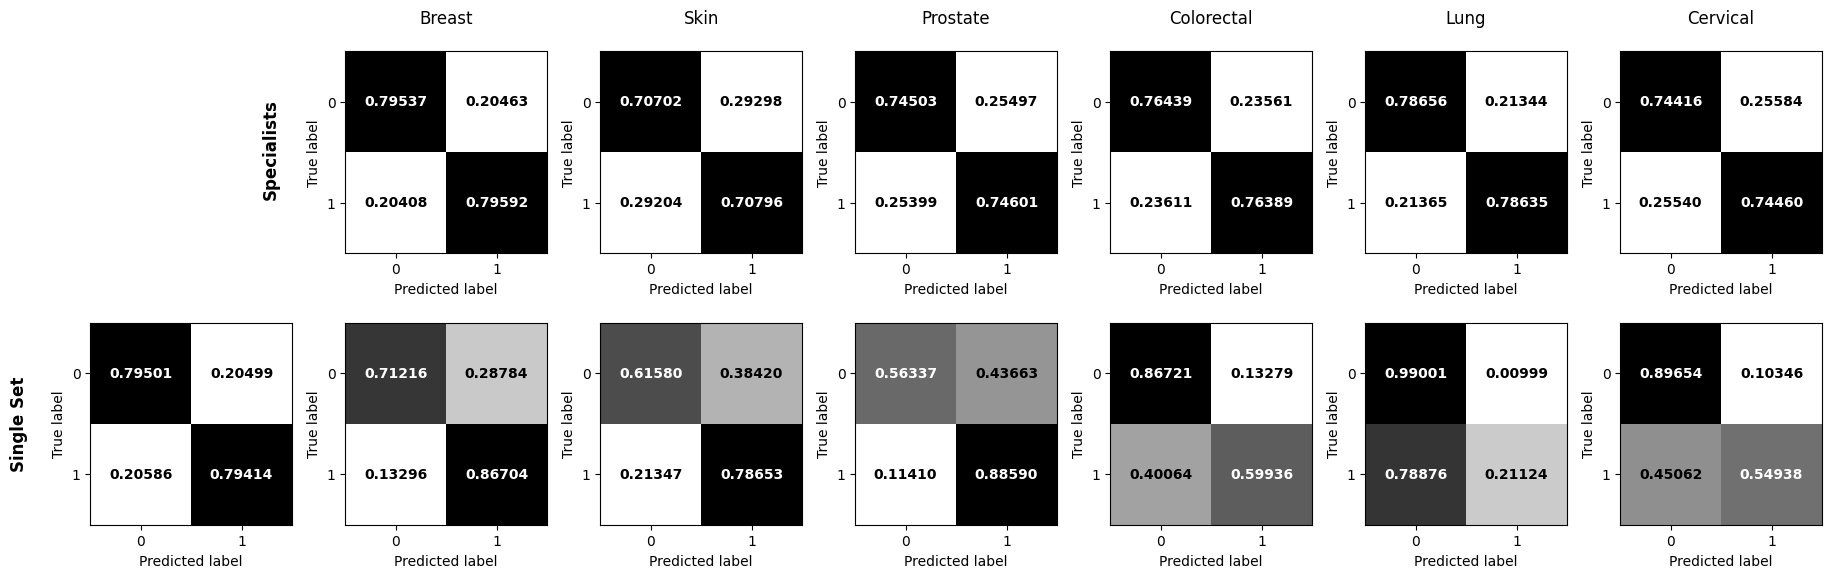

In [ ]:
# Títulos das colunas
titles = ['', 'Breast', 'Skin', 'Prostate', 'Colorectal', 'Lung', 'Cervical']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_mama, X_test_mama, y_test_mama),
                     2: (best_pele, X_test_pele, y_test_pele),
                     3: (best_prost, X_test_prost, y_test_prost),
                     4: (best_colo, X_test_colo, y_test_colo),
                     5: (best_pulm, X_test_pulm, y_test_pulm),
                     6: (best_colo_utero, X_test_colo_utero, y_test_colo_utero),
                     7: (best, X_test, y_test),
                     8: (best, X_test_mama_j, y_test_mama_j),
                     9: (best, X_test_pele_j, y_test_pele_j),
                     10: (best, X_test_prost_j, y_test_prost_j),
                     11: (best, X_test_colo_j, y_test_colo_j),
                     12: (best, X_test_pulm_j, y_test_pulm_j),
                     13: (best, X_test_colo_utero_j, y_test_colo_utero_j)}

position = [0.733, 0.275] # 0.88 - (row_idx / 6)

# Configuração da figura com 2 linhas e 7 colunas
fig, axes = plt.subplots(2, 7, figsize=(18, 6))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(7):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.13, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/incid_juntos.eps', bbox_inches='tight')